In [ ]:
'''
For connecting with datasets given in Data folder - 

Adding the folder to my drive and then mounting the drive over Google Colab
to make file from my drive accessible here
'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Importing libraries
"""

# For data Wrangling
import numpy as np
import pandas as pd

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Importing other libraries that may be helpful later
import math
import os, random
import pickle
from datetime import date
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Preventing warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
'''
STEP-1

Loading the load data
Since the data is parquet file, using pd.read_parquet()
'''

load_df = pd.read_parquet('/content/drive/MyDrive/w5-6/data/historical_load_data.parquet')
print(load_df.shape)
load_df

(394368, 4)


,datetime,date,load,tb
0,2011-04-01 00:00:00,2011-04-01,945.592,1
1,2011-04-01 00:15:00,2011-04-01,928.644,2
2,2011-04-01 00:30:00,2011-04-01,912.076,3
3,2011-04-01 00:45:00,2011-04-01,895.105,4
4,2011-04-01 01:00:00,2011-04-01,879.988,5
...,...,...,...,...
394363,2022-06-30 22:45:00,2022-06-30,2260.000,92
394364,2022-06-30 23:00:00,2022-06-30,2272.000,93
394365,2022-06-30 23:15:00,2022-06-30,2274.000,94
394366,2022-06-30 23:30:00,2022-06-30,2269.000,95


In [ ]:
"""
Getting the info about the columns of the dataframe
"""

load_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394368 entries, 0 to 394367
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  394368 non-null  datetime64[ns]
 1   date      394368 non-null  object        
 2   load      394368 non-null  float64       
 3   tb        394368 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 15.0+ MB


In [ ]:
'''
STEP-2

Changing the data type of columns to appropiate data types.
Here, date column which is object is changed to datetime64[ns] type

Using pd.to_datetime() for the same
'''

load_df['date'] = pd.to_datetime(load_df['date'])
load_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394368 entries, 0 to 394367
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  394368 non-null  datetime64[ns]
 1   date      394368 non-null  datetime64[ns]
 2   load      394368 non-null  float64       
 3   tb        394368 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 15.0 MB


No NaN values are there in the dataset

In [ ]:
"""
Checking the timeperiod for which data was given

Simply by checking the min and max time of the dataframe and subtracting to know the range of given data
"""

print(f'The data is from {load_df.datetime.min()} to {load_df.datetime.max()}, i.e. for {load_df.datetime.max() - load_df.datetime.min()} time.')

The data is from 2011-04-01 00:00:00 to 2022-06-30 23:45:00, i.e. for 4108 days 23:45:00 time.


### Examine the dates

In [ ]:
"""
Checking if entries of each date matches 96 entries.
And getting dates which do not had 96 entries
"""

load_df.groupby('date').count()[load_df.groupby('date').count()['datetime'] != 96]

,datetime,load,tb
date,,,


So, for all dates, we have 96 time blocks

**Checking for duplicates**

In [ ]:
load_df.duplicated().sum()

0

No duplicate rows as well

## **Checking for the missing data**

In [ ]:
"""
CHECKING FOR THE MISSING DATA

Checking the datetime of load_df datetime column with date range between start and end date
First we make a new dataframe dfx containing datetime between both the dates
Then merging it with load_df and checking the missing data

"""


from datetime import date

start_date = '2011-04-01'
end_date = '2022-06-30'

dfx = pd.DataFrame({
    'datetime': pd.date_range(start_date, periods=96*((date(2022, 6, 30) - date(2011, 4, 1)).days+1), freq='15T')
})

load_df = pd.merge(dfx, load_df, how='outer', on='datetime')
load_df

,datetime,date,load,tb
0,2011-04-01 00:00:00,2011-04-01,945.592,1.0
1,2011-04-01 00:15:00,2011-04-01,928.644,2.0
2,2011-04-01 00:30:00,2011-04-01,912.076,3.0
3,2011-04-01 00:45:00,2011-04-01,895.105,4.0
4,2011-04-01 01:00:00,2011-04-01,879.988,5.0
...,...,...,...,...
394459,2022-06-30 22:45:00,2022-06-30,2260.000,92.0
394460,2022-06-30 23:00:00,2022-06-30,2272.000,93.0
394461,2022-06-30 23:15:00,2022-06-30,2274.000,94.0
394462,2022-06-30 23:30:00,2022-06-30,2269.000,95.0


In [ ]:
"""
Since new load_df shape is 96 more, it means 1 date having 96 timeblocks is missing
Getting 1 row having missing value
"""

load_df[load_df.tb.isna() == True].iloc[1]

datetime    2020-12-21 00:15:00
date                        NaT
load                        NaN
tb                          NaN
Name: 340993, dtype: object

### **So, data for 12-21-2020 is missing**

In [ ]:
"""
Dropping the nan rows and getting our dataframe load_df as it was when loaded
"""

load_df.dropna(axis=0, inplace=True)
load_df.shape

(394368, 4)

In [ ]:
"""
STEP - 2

Loading the holiday data and marking holidays on load data
Using pd.read_csv() since data is a csv file
"""

holidays = pd.read_csv('/content/drive/MyDrive/w5-6/data/holidays.csv')
print(holidays.shape)
holidays

(11, 22)


,Republic Day,Milad un-Nabi/Id-e-Milad,Holi,Rama Navami,Mahavir Jayanti,Good Friday,Buddha Purnima/Vesak,Independence Day,Janmashtami,Ramzan Id/Eid-ul-Fitar,...,Diwali/Deepavali,Guru Nanak Jayanti,Muharram/Ashura,Christmas,Chhat Puja (Pratihar Sashthi/Surya Sashthi),Bank Holiday,Maha Shivratri,Children's Day,Maharishi Valmiki,Idul Juha
0,1/26/2011,2/16/2011,3/20/2011,4/12/2011,4/16/2011,4/22/2011,5/17/2011,8/15/2011,8/22/2011,9/1/2011,...,10/26/2011,11/10/2011,12/6/2011,12/25/2011,11/1/2011,4/1/2011,3/2/2011,11/14/2011,10/11/2011,11/6/2011
1,1/26/2012,2/5/2012,3/8/2012,4/1/2012,4/5/2012,4/6/2012,5/6/2012,8/15/2012,8/10/2012,8/20/2012,...,11/13/2012,11/28/2012,11/25/2012,12/25/2012,11/19/2012,4/1/2012,2/20/2012,11/14/2012,10/29/2012,10/26/2012
2,1/26/2013,1/25/2013,3/27/2013,4/19/2013,4/24/2013,3/29/2013,5/25/2013,8/15/2013,8/28/2013,8/9/2013,...,11/3/2013,11/17/2013,11/14/2013,12/25/2013,11/8/2013,4/1/2013,3/10/2013,11/14/2013,10/18/2013,10/15/2013
3,1/26/2014,1/14/2014,3/16/2014,4/8/2014,4/13/2014,4/18/2014,5/14/2014,8/15/2014,8/17/2014,7/29/2014,...,10/23/2014,11/6/2014,11/4/2014,12/25/2014,10/29/2014,4/1/2014,2/27/2014,11/14/2014,10/8/2014,10/6/2014
4,1/26/2015,1/4/2015,3/17/2014,3/28/2015,4/2/2015,4/3/2015,5/4/2015,8/15/2015,9/5/2015,7/19/2015,...,11/11/2015,11/25/2015,10/24/2015,12/25/2015,11/17/2015,4/1/2015,2/17/2015,11/14/2015,10/27/2015,9/25/2015
5,1/26/2016,12/13/2016,3/6/2015,4/15/2016,4/20/2016,3/25/2016,5/21/2016,8/15/2016,8/25/2016,7/6/2016,...,10/30/2016,11/14/2016,10/12/2016,12/25/2016,11/6/2016,4/1/2016,3/7/2016,11/14/2016,10/15/2016,9/12/2016
6,1/26/2017,12/2/2017,3/24/2016,4/4/2017,4/9/2017,4/14/2017,5/10/2017,8/15/2017,8/15/2017,6/26/2017,...,10/19/2017,11/4/2017,10/1/2017,12/25/2017,10/26/2017,4/1/2017,2/24/2017,11/14/2017,10/5/2017,9/2/2017
7,1/26/2018,11/21/2018,3/13/2017,3/25/2018,3/29/2018,3/30/2018,4/30/2018,8/15/2018,9/3/2018,6/15/2018,...,11/7/2018,11/23/2018,9/21/2018,12/25/2018,11/13/2018,4/1/2018,2/13/2018,11/14/2018,10/24/2018,8/22/2018
8,1/26/2019,11/10/2019,3/2/2018,4/13/2019,4/17/2019,4/19/2019,5/18/2019,8/15/2019,8/24/2019,6/5/2019,...,10/27/2019,11/12/2019,9/10/2019,12/25/2019,11/2/2019,4/1/2019,3/4/2019,11/14/2019,10/13/2019,8/12/2019
9,1/26/2020,10/29/2020,3/10/2020,4/2/2020,4/6/2020,4/10/2020,5/7/2020,8/15/2020,8/11/2020,5/24/2020,...,11/14/2020,11/30/2020,8/20/2020,12/25/2020,11/20/2020,4/1/2020,2/21/2020,11/14/2020,10/31/2020,7/31/2020


In [ ]:
"""
Checking for the holidays NaN values, if any
"""

holidays.isna().sum()

Republic Day                                   0
Milad un-Nabi/Id-e-Milad                       0
Holi                                           0
Rama Navami                                    0
Mahavir Jayanti                                0
Good Friday                                    0
Buddha Purnima/Vesak                           0
Independence Day                               0
Janmashtami                                    0
Ramzan Id/Eid-ul-Fitar                         0
Mahatma Gandhi Jayanti                         0
Dussehra (Maha Navami)                         0
Diwali/Deepavali                               0
Guru Nanak Jayanti                             0
Muharram/Ashura                                0
Christmas                                      0
Chhat Puja (Pratihar Sashthi/Surya Sashthi)    0
Bank Holiday                                   0
Maha Shivratri                                 0
Children's Day                                 0
Maharishi Valmiki   

In [ ]:
"""
Using pd.melt() to melt the holidays dataframe and then merging that to load_df dataframe that flags for holidays

"""

holiday_df = pd.melt(holidays, var_name='holiday_name', value_name='holiday_date')
holiday_df

,holiday_name,holiday_date
0,Republic Day,1/26/2011
1,Republic Day,1/26/2012
2,Republic Day,1/26/2013
3,Republic Day,1/26/2014
4,Republic Day,1/26/2015
...,...,...
237,Idul Juha,9/2/2017
238,Idul Juha,8/22/2018
239,Idul Juha,8/12/2019
240,Idul Juha,7/31/2020


In [ ]:
"""
Now, merging the holiday_df to load_df giving the flag for holidays
"""

holiday_df['date'] = pd.to_datetime(holiday_df['holiday_date']).dt.date
load_df['HOLIDAY FLAG'] = load_df['date'].isin(holiday_df['date']).map({
    False: 0,
    True: 1
})

load_df

,datetime,date,load,tb,HOLIDAY FLAG
0,2011-04-01 00:00:00,2011-04-01,945.592,1.0,1
1,2011-04-01 00:15:00,2011-04-01,928.644,2.0,1
2,2011-04-01 00:30:00,2011-04-01,912.076,3.0,1
3,2011-04-01 00:45:00,2011-04-01,895.105,4.0,1
4,2011-04-01 01:00:00,2011-04-01,879.988,5.0,1
...,...,...,...,...,...
394459,2022-06-30 22:45:00,2022-06-30,2260.000,92.0,0
394460,2022-06-30 23:00:00,2022-06-30,2272.000,93.0,0
394461,2022-06-30 23:15:00,2022-06-30,2274.000,94.0,0
394462,2022-06-30 23:30:00,2022-06-30,2269.000,95.0,0


In [ ]:
"""
Counting the Total Holidays count
"""

load_df['HOLIDAY FLAG'].value_counts()

0    372000
1     22368
Name: HOLIDAY FLAG, dtype: int64

In [ ]:
"""
Dropping the rows containing holidays dates

"""

df = load_df.drop(index=load_df.index[load_df['HOLIDAY FLAG'] == 1])
print(load_df.shape, df.shape)

(394368, 5) (372000, 5)


In [ ]:
# Dropping the 'HOLIDAY FLAG' column

df = df.drop(columns=['HOLIDAY FLAG'])
df

,datetime,date,load,tb
96,2011-04-02 00:00:00,2011-04-02,933.476,1.0
97,2011-04-02 00:15:00,2011-04-02,917.484,2.0
98,2011-04-02 00:30:00,2011-04-02,904.468,3.0
99,2011-04-02 00:45:00,2011-04-02,890.156,4.0
100,2011-04-02 01:00:00,2011-04-02,881.604,5.0
...,...,...,...,...
394459,2022-06-30 22:45:00,2022-06-30,2260.000,92.0
394460,2022-06-30 23:00:00,2022-06-30,2272.000,93.0
394461,2022-06-30 23:15:00,2022-06-30,2274.000,94.0
394462,2022-06-30 23:30:00,2022-06-30,2269.000,95.0


In [ ]:
"""
Making a new dataframe for all days with data of load missing for holidays

datetime column: using pd.date_range() for all dates having 96 timeblock for each day
date column: date taken from datetime
tb column: using same method as used in previous task (Using minutes of the day)
load column: merging load_df[['datetime', 'load']] columns of load_df dataframe having ['HOLIDAY FLAG'] set to 0 with df on 'datetime' column using outer join
"""
from datetime import date

start_date = '2011-04-01'
end_date = '2022-06-30'

df2 = pd.DataFrame({
    'datetime': pd.date_range(start_date, periods=96*((date(2022, 6, 30) - date(2011, 4, 1)).days+1), freq='15T')
})

df2['date'] = df2.datetime.dt.date
df2['tb'] = (df2.datetime.dt.hour*60 + df2.datetime.dt.minute)//15 +1

df2 = pd.merge(df2, df[['datetime', 'load']], how='left', on='datetime')

df2

,datetime,date,tb,load
0,2011-04-01 00:00:00,2011-04-01,1,NaN
1,2011-04-01 00:15:00,2011-04-01,2,NaN
2,2011-04-01 00:30:00,2011-04-01,3,NaN
3,2011-04-01 00:45:00,2011-04-01,4,NaN
4,2011-04-01 01:00:00,2011-04-01,5,NaN
...,...,...,...,...
394459,2022-06-30 22:45:00,2022-06-30,92,2260.0
394460,2022-06-30 23:00:00,2022-06-30,93,2272.0
394461,2022-06-30 23:15:00,2022-06-30,94,2274.0
394462,2022-06-30 23:30:00,2022-06-30,95,2269.0


In [ ]:
"""
Checking for nan values of load column
"""

df2.isna().sum()

datetime        0
date            0
tb              0
load        22464
dtype: int64

Clearly, df2 having datetime from 2011-04-01 to 2022-06-30 has 96 more rows than load_df having same date range.

This means 1 date is missing in load_df, as as found earlier, it was of 12-21-2020

**Here, in df2, our dataframe has all the datetime values now**


## EDA

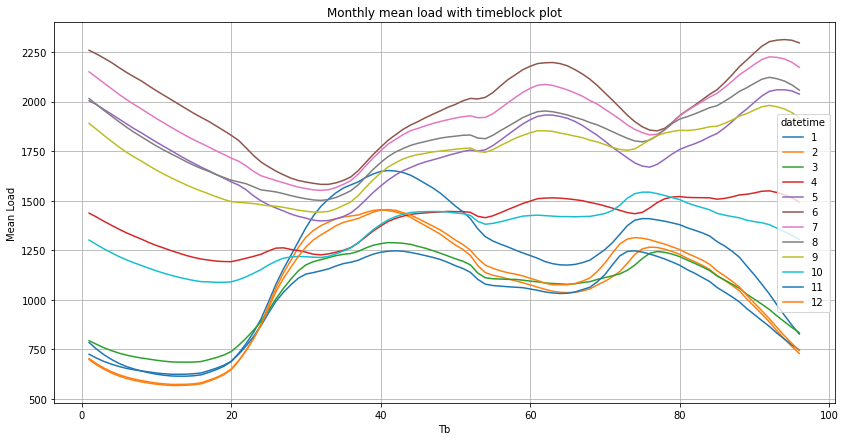

In [ ]:
"""
Monthly mean load consumption with tb
"""

fig, ax = plt.subplots(1, figsize=(14, 7))
df2.groupby([df2.datetime.dt.month, 'tb']).load.mean().unstack().T.plot(ax=ax)

ax.grid('on')
ax.set_xlabel('Tb')
ax.set_ylabel('Mean Load')
ax.set_title('Monthly mean load with timeblock plot');

As expected, loads were less during winter months and more during summer months

Also, its lesser during morning and midnight hours compared to daytime

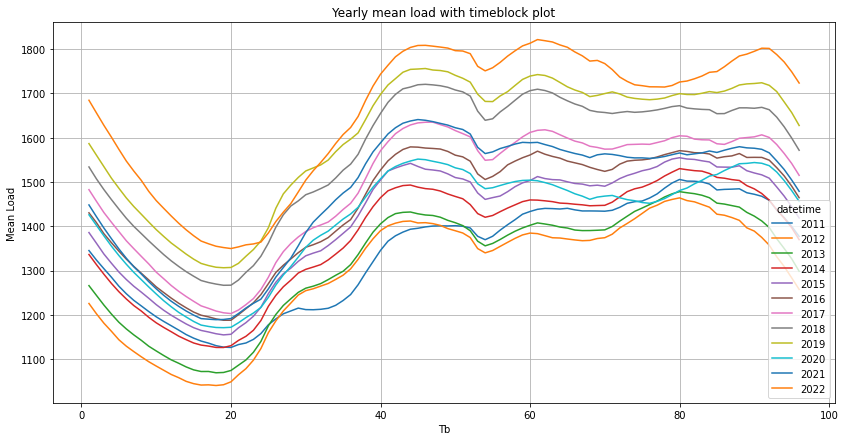

In [ ]:
"""
Yearly mean load consumption with tb
"""

fig, ax = plt.subplots(1, figsize=(14, 7))
df2.groupby([df2.datetime.dt.year, 'tb']).load.mean().unstack().T.plot(ax=ax)

ax.grid('on')
ax.set_xlabel('Tb')
ax.set_ylabel('Mean Load')
ax.set_title('Yearly mean load with timeblock plot');

Pattern shown here for all years is almost similar..
Just a difference being the load, which keep on increasing during each year.
This may be because of climate change(increasing temperatures) and can be due to population growth in Delhi

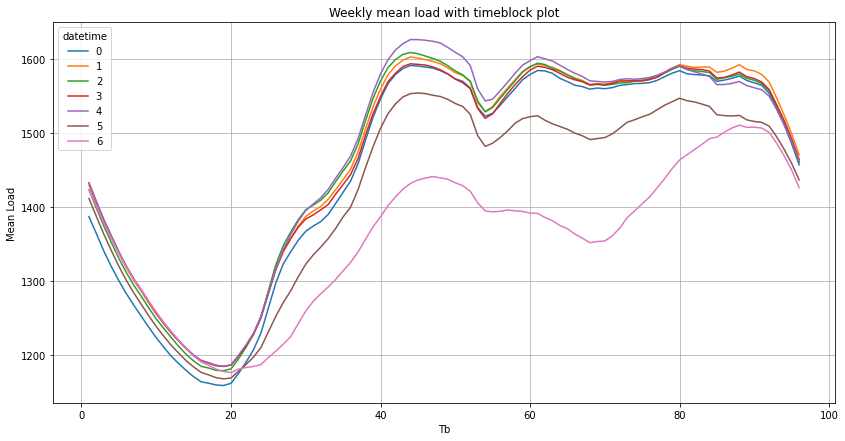

In [ ]:
"""
Weekly mean load consumption with tb
"""

fig, ax = plt.subplots(1, figsize=(14, 7))
df2.groupby([df2.datetime.dt.weekday, 'tb']).load.mean().unstack().T.plot(ax=ax)

ax.grid('on')
ax.set_xlabel('Tb')
ax.set_ylabel('Mean Load')
ax.set_title('Weekly mean load with timeblock plot');

Lower consumption on weekends and highest on weekdays (working days)

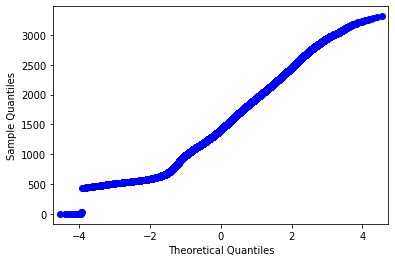

<Figure size 864x432 with 0 Axes>

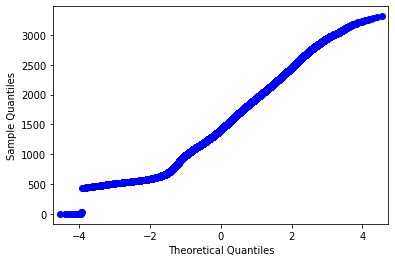

In [ ]:
"""
Plotting the qq-plot to see distribution of load
"""

import statsmodels.api as sm

plt.figure(figsize=(12, 6))

sm.qqplot(df2['load'].dropna())

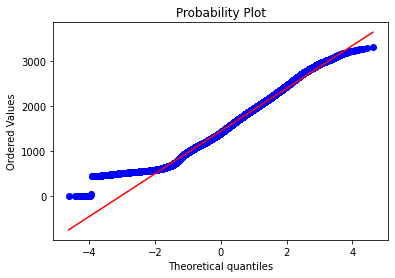

In [ ]:
"""
Plotting probplot
"""

import pylab
import scipy.stats as stat

stat.probplot(df2['load'].dropna(), dist='norm', plot=pylab)
plt.show()

It looks close like normal distribution, except at the starting

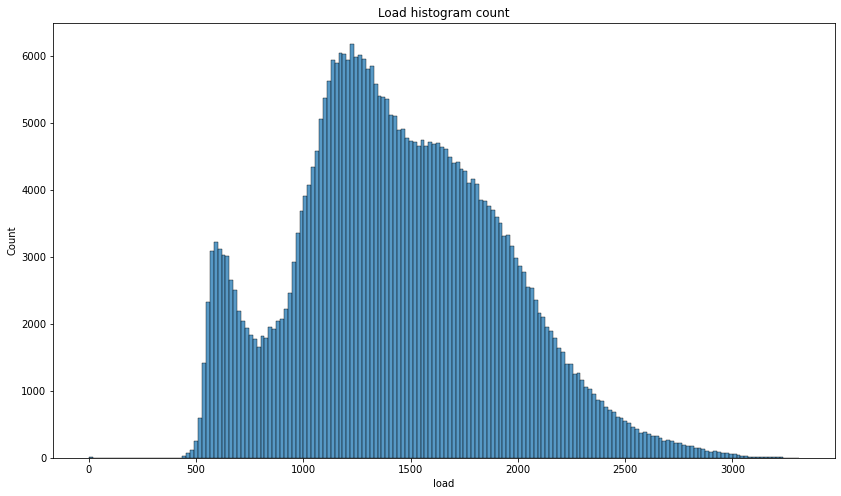

In [ ]:
"""
Plotting the load histogram
"""

plt.figure(figsize=(14, 8))
sns.histplot(df2['load'])
plt.title('Load histogram count')
plt.show()

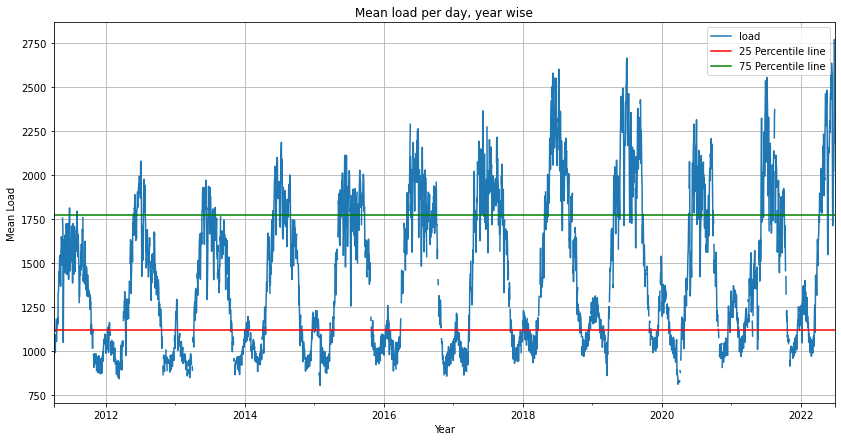

In [ ]:
"""
Plotting for each day
"""

fig, ax = plt.subplots(1, figsize=(14, 7))
df2.set_index('datetime').resample('D').load.mean().plot(ax=ax)
ax.axhline(df2.load.quantile(0.25), color='r', label='25 Percentile line')
ax.axhline(df2.load.quantile(0.75), color='g', label='75 Percentile line')
ax.legend()

ax.grid('on')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Load')
ax.set_title('Mean load per day, year wise');

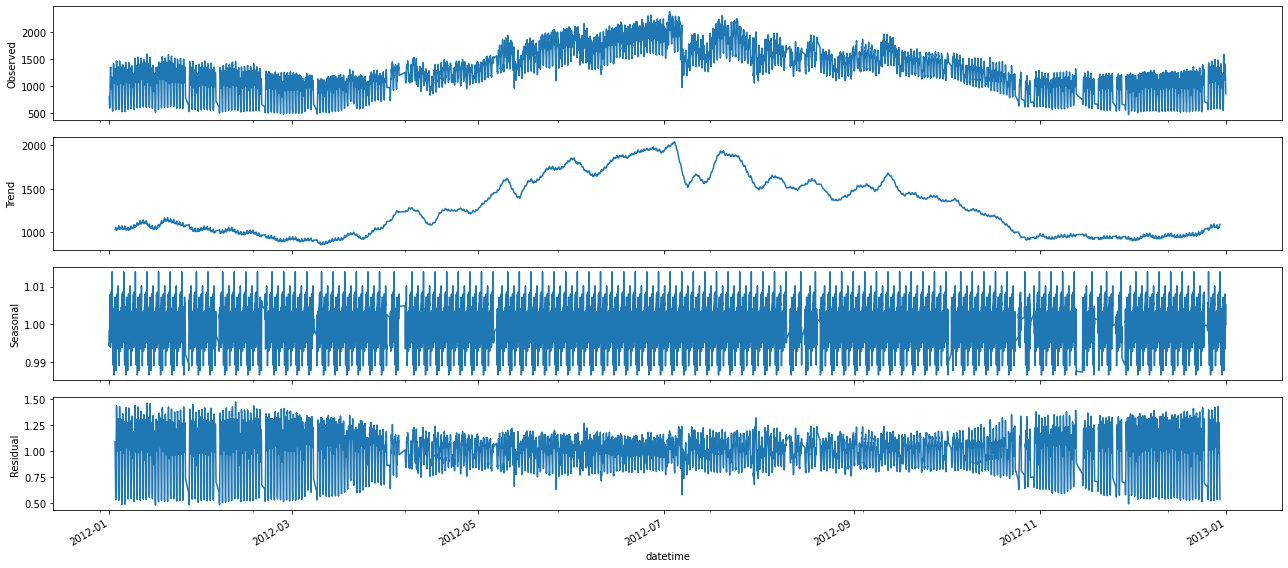

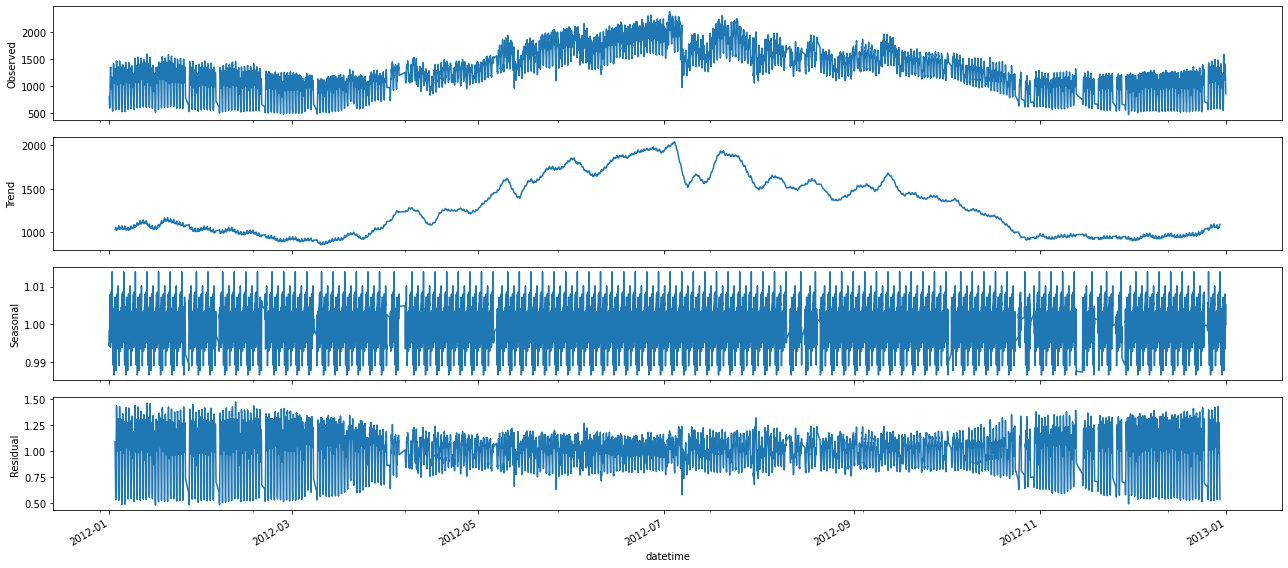

In [ ]:
"""
Plotting Time Series tread, seasonality and other details
"""

from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams

rcParams['figure.figsize'] = 18, 8

season = df2[(df2.datetime >= '2012-01-01') & (df2.datetime < '2013-01-01')].set_index('datetime').load.dropna()
result = seasonal_decompose(season, model='multiplicative', freq=365)
result.plot()

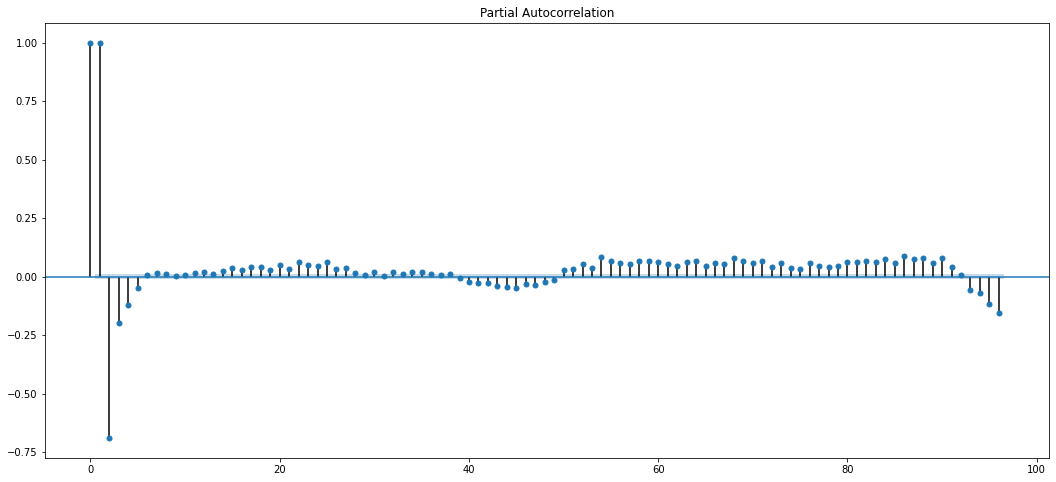

<Figure size 1008x576 with 0 Axes>

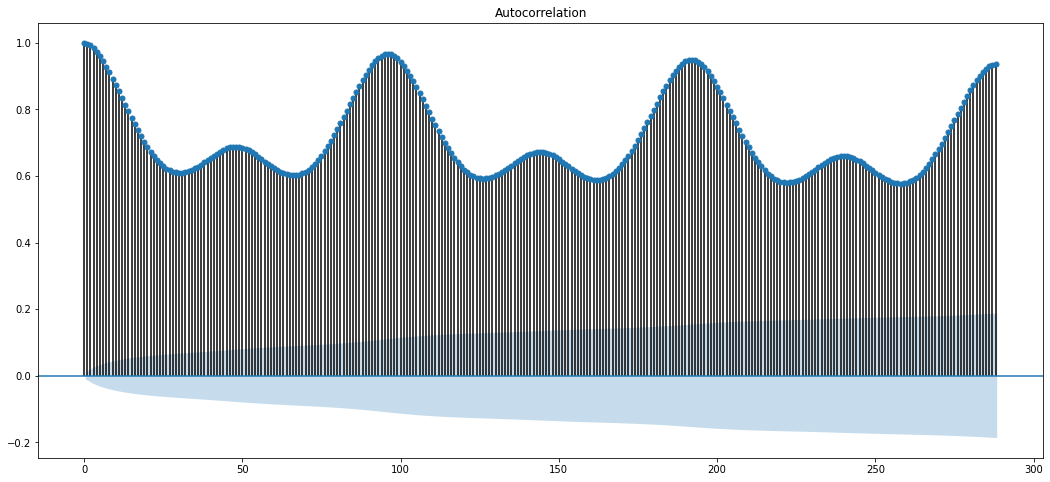

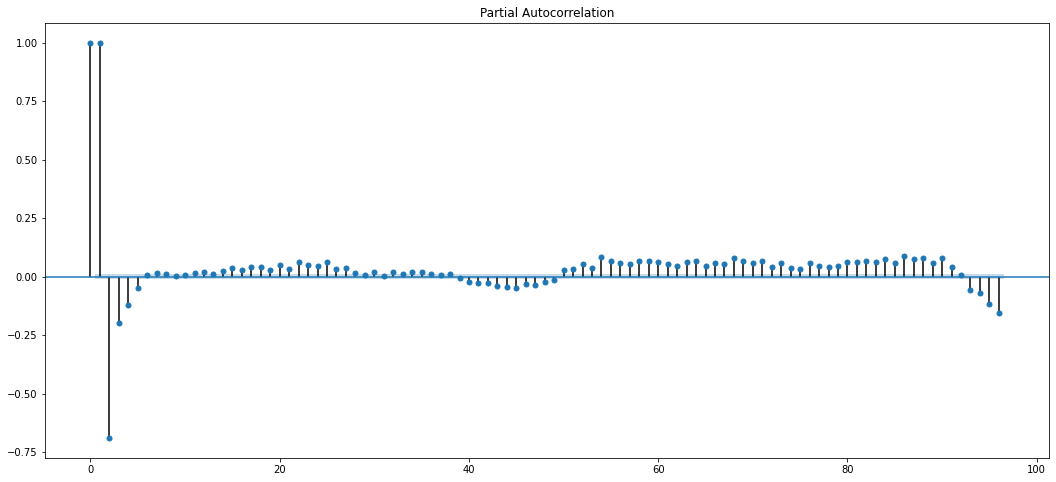

In [ ]:
"""
Plotting the PACF and ACF graph
"""

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

season = df2[(df2.datetime >= '2012-01-01') & (df2.datetime < '2013-01-01')].load.dropna()
plt.figure(figsize=(14, 8))
plot_acf(season, lags=96*3)
plot_pacf(season, lags=96)

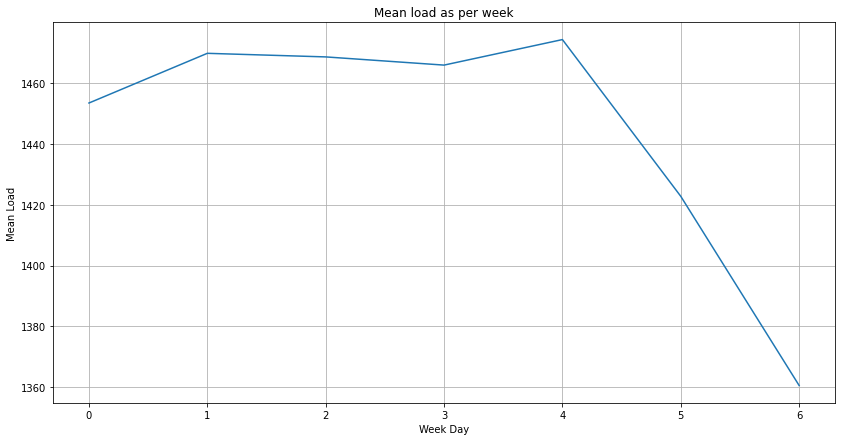

In [ ]:
"""
Weekly consumption of load
"""

fig, ax = plt.subplots(1, figsize=(14, 7))
df.groupby(df2.datetime.dt.weekday).load.mean().plot()

ax.grid('on')
ax.set_xlabel('Week Day')
ax.set_ylabel('Mean Load')
ax.set_title('Mean load as per week');

Lowest load consumption on weekends when most of the offices and industries/etc are closed

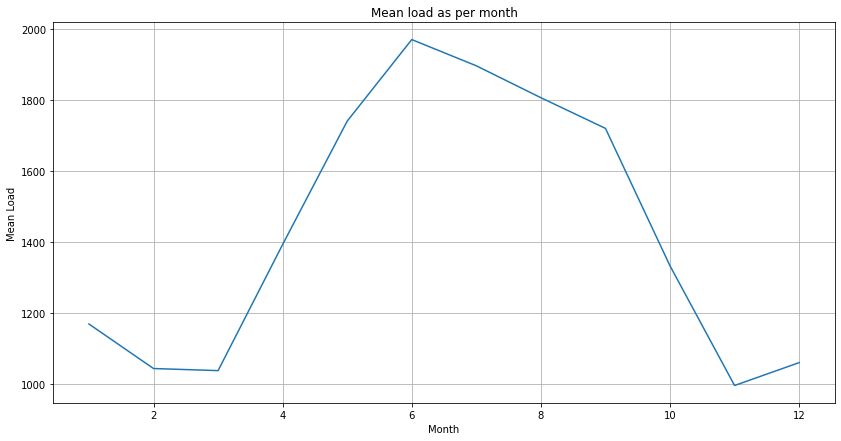

In [ ]:
"""
Monthly average consumption of load
"""

fig, ax = plt.subplots(1, figsize=(14, 7))
df.groupby(df2.datetime.dt.month).load.mean().plot()

ax.grid('on')
ax.set_xlabel('Month')
ax.set_ylabel('Mean Load')
ax.set_title('Mean load as per month');

Highest during summer and lower during winters

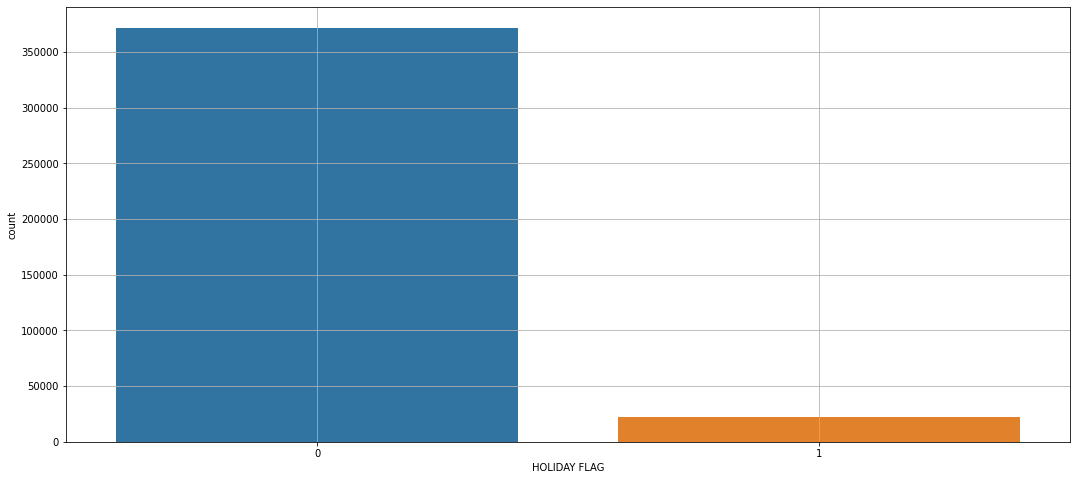

In [ ]:
# Counting the total number of holidays/non-holidays days

sns.countplot(load_df['HOLIDAY FLAG'])
plt.grid('on');

In [ ]:
# Percentage of holidays 

(load_df.groupby(['HOLIDAY FLAG']).date.count()[1] / len(load_df))*100

5.671859785783837

Of all data, about 5.67% dates were holidays

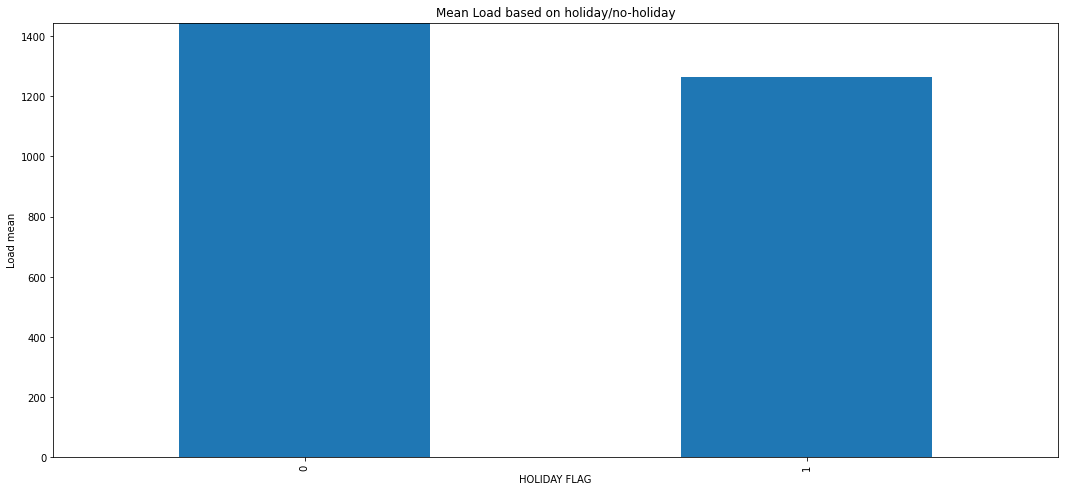

In [ ]:
"""
Plotting mean load based on 'HOLIDAY FLAG'
"""


load_df.groupby(['HOLIDAY FLAG']).load.mean().plot(kind='bar')
plt.ylabel('Load mean')
plt.title('Mean Load based on holiday/no-holiday')
plt.axis('on')
plt.ylim([0, max(load_df.groupby(['HOLIDAY FLAG']).load.mean())])
plt.show()

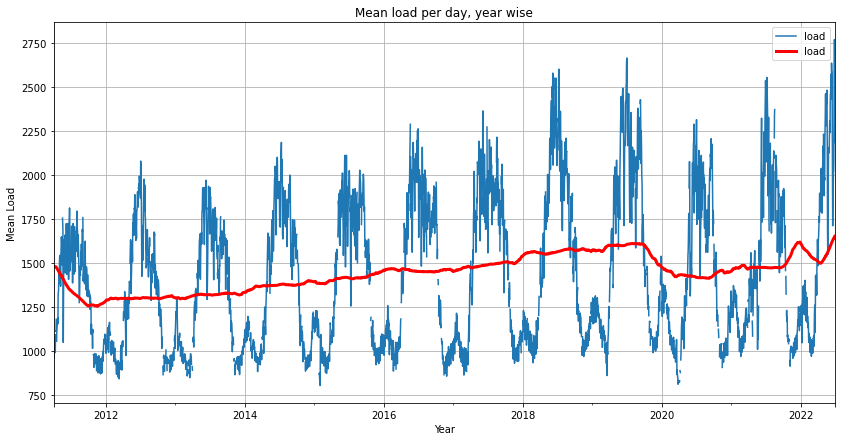

In [ ]:
"""
Getting trend using Rolling Mean
"""

roll = df2.set_index('datetime').resample('D')['load'].mean().rolling(
    window = 365,
    center = True,
    min_periods = 183
).mean()

fig, ax = plt.subplots(1, figsize=(14, 7))
df2.set_index('datetime').resample('D').load.mean().plot(ax=ax)
roll.plot(color='r', style='-', ax=ax, linewidth=3)
ax.legend()

ax.grid('on')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Load')
ax.set_title('Mean load per day, year wise');

Irregular trend can be seen here

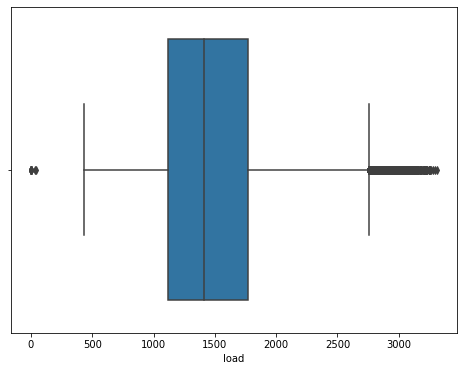

In [ ]:
"""
Checking the Outliers by boxplots
"""

plt.figure(figsize=(8, 6))
sns.boxplot(df2.load)

In [ ]:
"""
OUTLIER DETECTION using IQR

Q1 = 25 percentile value of load (computed using np.qunatile(0.25))
Q3 = 75 percentile value of load
IQR = Q3 - Q1

Any value will be outlier if it exceeds (Q3 + 105 * IQR) or if it is lesser than (Q1 - 105 * IQR)

"""


Q1 = df2.load.quantile(0.25)
Q3 = df2.load.quantile(0.75)
IQR = Q3 - Q1

low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

print(df2[(df2.load < low) | (df2.load > high)].shape)

df2['IQR_OUTLIER'] = ((df2.load < low) | (df2.load > high))
df2.head()

(1906, 4)


,datetime,date,tb,load,IQR_OUTLIER
0,2011-04-01 00:00:00,2011-04-01,1,NaN,False
1,2011-04-01 00:15:00,2011-04-01,2,NaN,False
2,2011-04-01 00:30:00,2011-04-01,3,NaN,False
3,2011-04-01 00:45:00,2011-04-01,4,NaN,False
4,2011-04-01 01:00:00,2011-04-01,5,NaN,False


**So, we have 1906 outliers**

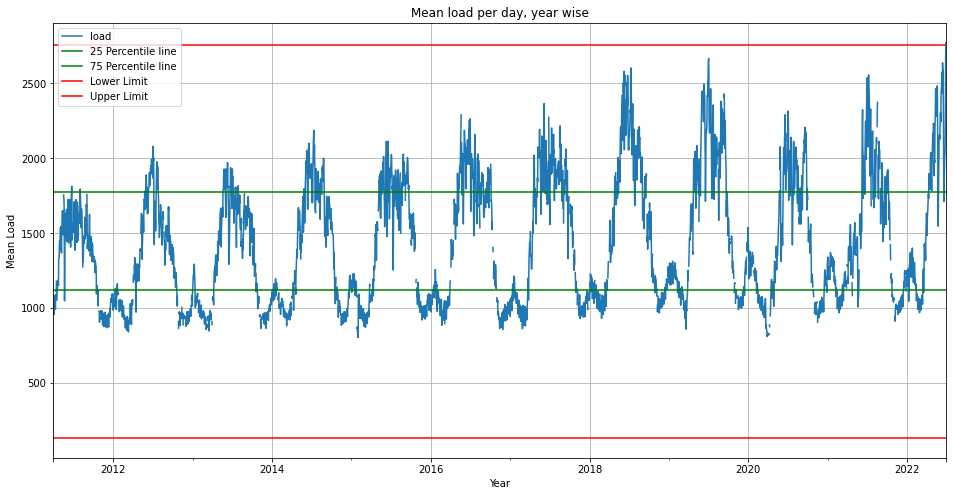

In [ ]:
"""
Plotting for each day

Plotting Q1, Q3, min and max range with the data too
"""

fig, ax = plt.subplots(1, figsize=(16, 8))
df2.set_index('datetime').resample('D').load.mean().plot(ax=ax)
ax.axhline(df2.load.quantile(0.25), color='g', label='25 Percentile line')
ax.axhline(df2.load.quantile(0.75), color='g', label='75 Percentile line')
ax.axhline(Q1 - 1.5*IQR, color='r', label='Lower Limit')
ax.axhline(Q3 + 1.5*IQR, color='r', label='Upper Limit')
ax.legend()

ax.grid('on')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Load')
ax.set_title('Mean load per day, year wise');

In [ ]:
# Getting the count, mean, min and max of outlier grouped by year and month

df2[df2['IQR_OUTLIER'] == True].groupby([df2.datetime.dt.year, df2.datetime.dt.month])['load'].agg(['count', 'mean', 'min', 'max'])

count         mean      min      max
datetime datetime                                      
2015     12           14     0.000000     0.00     0.00
2016     1             2    34.000000    30.00    38.00
2018     5             8  2813.396250  2759.56  2843.97
         6           290  2844.434828  2758.68  3012.04
         7           113  2871.362478  2762.29  3081.63
2019     6           256  2840.484453  2759.17  3031.58
         7           215  2911.661349  2760.17  3178.86
         8            25  2800.313200  2760.40  2845.71
         9            33  2823.831818  2762.96  2935.99
2020     6            10  2785.424000  2761.64  2808.13
         7             5  2781.496000  2764.05  2819.34
2021     6            49  2843.424490  2761.96  3012.23
         7           195  2879.828564  2759.00  3067.76
         8            16  2807.134375  2763.83  2859.00
2022     5           184  2879.284348  2758.53  3138.57
         6           491  2947.593198  2759.42  3311.00

In [ ]:
# Getting the count, mean, min and max of outlier grouped by year

df2[df2['IQR_OUTLIER'] == True].groupby([df2.datetime.dt.year])['load'].agg(['count', 'mean', 'min', 'max'])

,count,mean,min,max
datetime,,,,
2015,14,0.000000,0.00,0.00
2016,2,34.000000,30.00,38.00
2018,411,2851.234136,2758.68,3081.63
2019,529,2866.475406,2759.17,3178.86
2020,15,2784.114667,2761.64,2819.34
2021,260,2868.494308,2759.00,3067.76
2022,675,2928.972711,2758.53,3311.00


As we look into the yearly and monthly outliers, it is observed that 2018, 2019, 2021 and 2022 has most outliers

With 2022 having most

Most outliers for these years are in month 5 and 6 (may and june - summer)

In 2020, during Corona we had very less outliers - This may be because of closed offices and industries during Summers

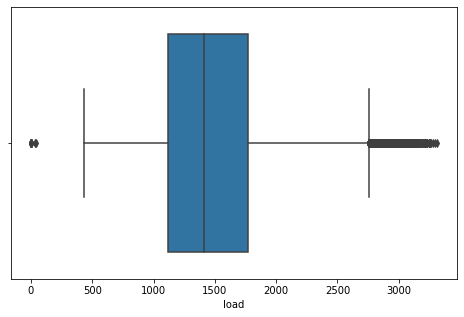

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(df2.load)

## Creating more features

In [ ]:
df2.head(2)

,datetime,date,tb,load,IQR_OUTLIER
0,2011-04-01 00:00:00,2011-04-01,1,NaN,False
1,2011-04-01 00:15:00,2011-04-01,2,NaN,False


In [ ]:
"""
Creating addition features:

Although seasons and time are irregular in India, based on common observations, 
following properties of features can be drafted.

isMorning - morning 6 am to 12 noon
isAfternoon - afternoon 12 noon to 4pm
isEvening - evening 4pm to 7pm
isNight - night 7pm to 6am

is_summer - april, may, june
is_rainy - july, august, september
is_autumn - october, november
is_winter - december, january
is_spring - february, march

Other features are:
# THESE FEATURES ARE TAKEN FROM LAST NOTEBOOK PRACTICE ASSIGNMENT

cos_tb, sin_tb
cos_hour, sin_hour
load_lag
load_rolling_mean
load_mw
ramp
"""

df2['year'] = df2.datetime.dt.year
df2['month'] = df2.datetime.dt.month
df2['hour'] = df2.datetime.dt.hour
df2['dow'] = df2.datetime.dt.day_of_week
df2['doy'] = df2.datetime.dt.day_of_year
df2['week'] = df2.datetime.dt.week

df2['isMorning'] = ((df2.datetime.dt.hour > 6) & (df2.datetime.dt.hour <= 12)).astype(int)
df2['isAfternoon'] = ((df2.datetime.dt.hour > 12) & (df2.datetime.dt.hour <= 16)).astype(int)
df2['isEvening'] = ((df2.datetime.dt.hour > 16) & (df2.datetime.dt.hour <= 19)).astype(int)
df2['isNight'] = ((df2.datetime.dt.hour > 19) | (df2.datetime.dt.hour <= 6)).astype(int)


df2['is_summer'] = ((df2.month > 3) & (df2.month <= 6)).astype(int) # April, may, june
df2['is_rainy'] = ((df2.month > 6) & (df2.month <= 9)).astype(int) # july, august, september
df2['is_autumn'] = ((df2.month > 9) & (df2.month <= 11)).astype(int) # october, november
df2['is_winter'] = ((df2.month > 11) | (df2.month <= 1)).astype(int) # december, january
df2['is_spring'] = ((df2.month > 1) & (df2.month <= 3)).astype(int) # february, march


df2['norm'] = 2 * np.pi * df2['tb'] / df2['tb'].max()
df2['cos_tb'] = np.cos(df2['norm'])
df2['sin_tb'] = np.sin(df2['norm'])

df2['norm'] = 2 * np.pi * df2['hour'] / df2['hour'].max()
df2['cos_hour'] = np.cos(df2['norm'])
df2['sin_hour'] = np.sin(df2['norm'])

df2['norm'] = 2 * np.pi * df2['dow'] / df2['dow'].max()
df2['cos_dow'] = np.cos(df2['dow'])
df2['sin_dow'] = np.sin(df2['dow'])

df2['norm'] = 2 * np.pi * df2['doy'] / df2['doy'].max()
df2['cos_doy'] = np.cos(df2['doy'])
df2['sin_doy'] = np.sin(df2['doy'])

df2 = df2.drop(columns=['norm'])

for i in [1, 2, 3, 4, 8, 96, 192]:
  df2[f'load_lag_{i}'] = df2['load'].shift(i).bfill()

for x in [4, 8, 12, 24, 48, 96]:
  df2[f'load_rolling_mean_{x}'] = df2['load'].rolling(x, 1).mean().shift().bfill()
  df2[f'load_rolling_max_{x}'] = df2['load'].rolling(x, 1).max().shift().bfill()
  df2[f'load_rolling_min_{x}'] = df2['load'].rolling(x, 1).min().shift().bfill()


for x in [4, 8, 12, 24, 48, 96]:
  df2[f'load_wm_{x/4}_h'] = df2['load'].ewm(span=x).mean()


df2['ramp1'] = df2['load'] - df2['load'].shift(1)
df2['ramp2'] = df2['load'].shift(1) - df2['load'].shift(2)
df2['ramp3'] = df2['load'].shift(2) - df2['load'].shift(3)
df2['ramp4'] = df2['load'].shift(3) - df2['load'].shift(4)


hour_mean = df2.groupby(['date', 'hour']).load.mean().reset_index()
hour_mean = hour_mean.rename(columns = {'load': 'hour_mean'})
print(df2.shape)
df2 = pd.merge(df2, hour_mean, on=['date', 'hour'], how='left')
print(df2.shape)


df2.head()

(394464, 63)
(394464, 64)


,datetime,date,tb,load,IQR_OUTLIER,year,month,hour,dow,doy,...,load_wm_2.0_h,load_wm_3.0_h,load_wm_6.0_h,load_wm_12.0_h,load_wm_24.0_h,ramp1,ramp2,ramp3,ramp4,hour_mean
0,2011-04-01 00:00:00,2011-04-01,1,NaN,False,2011,4,0,4,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-04-01 00:15:00,2011-04-01,2,NaN,False,2011,4,0,4,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-04-01 00:30:00,2011-04-01,3,NaN,False,2011,4,0,4,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-04-01 00:45:00,2011-04-01,4,NaN,False,2011,4,0,4,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-04-01 01:00:00,2011-04-01,5,NaN,False,2011,4,1,4,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df2.isna().sum()[df2.isna().sum() > 0]

load              22464
load_wm_1.0_h        96
load_wm_2.0_h        96
load_wm_3.0_h        96
load_wm_6.0_h        96
load_wm_12.0_h       96
load_wm_24.0_h       96
ramp1             22683
ramp2             22684
ramp3             22685
ramp4             22686
hour_mean         22464
dtype: int64

### Getting and working with weather dataset

In [ ]:
"""
Loading the weather data using pd.read_parquet()

"""

weather = pd.read_parquet('/content/drive/MyDrive/w5-6/data/weather_data.parquet')
print(weather.shape)
weather

(403872, 7)


,datetime,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover
0,2011-01-01 00:00:00,8.4400,9.6800,0.9500,8.950,2.5100,0.3000
1,2011-01-01 00:15:00,8.2575,9.4825,0.9625,8.935,2.4425,0.3025
2,2011-01-01 00:30:00,8.0750,9.2850,0.9750,8.920,2.3750,0.3050
3,2011-01-01 00:45:00,7.8925,9.0875,0.9875,8.905,2.3075,0.3075
4,2011-01-01 01:00:00,7.7100,8.8900,1.0000,8.890,2.2400,0.3100
...,...,...,...,...,...,...,...
403867,2022-07-05 22:45:00,42.3275,34.4950,0.5700,24.790,4.0900,0.7750
403868,2022-07-05 23:00:00,42.1700,34.2800,0.5800,24.880,4.2100,0.7800
403869,2022-07-05 23:15:00,40.2500,32.2500,0.6600,25.000,3.0000,0.5700
403870,2022-07-05 23:30:00,40.0000,32.0000,0.6600,25.000,3.0000,0.5600


In [ ]:
# Getting info of the dataframe

weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403872 entries, 0 to 403871
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   datetime              403872 non-null  datetime64[ns]
 1   apparent_temperature  403872 non-null  float64       
 2   temperature           403872 non-null  float64       
 3   humidity              403872 non-null  float64       
 4   dew_point             403872 non-null  float64       
 5   wind_speed            403872 non-null  float64       
 6   cloud_cover           403872 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 21.6 MB


In [ ]:
"""
Getting details of the date whose count is not 96
"""

weather.groupby(weather.datetime.dt.date).humidity.count()[weather.groupby(weather.datetime.dt.date).humidity.count() != 96]

datetime
2022-07-01    192
2022-07-02    192
2022-07-03    192
Name: humidity, dtype: int64

In [ ]:
"""
There seems to have some duplicate rows
Dropping duplicates using pd.drop_duplicates()

"""

weather.drop_duplicates(inplace=True)
weather.shape

(403584, 7)

In [ ]:
"""
Getting details of the updated dataframe whose count is not 96
"""

weather.groupby(weather.datetime.dt.date).humidity.count()[weather.groupby(weather.datetime.dt.date).humidity.count() != 96]

Series([], Name: humidity, dtype: int64)

In [ ]:
"""
Getting the min and max data of the given data
And also getting range of datetime this data is for.

"""

weather.datetime.min(), weather.datetime.max(), weather.datetime.max() - weather.datetime.min()

(Timestamp('2011-01-01 00:00:00'),
 Timestamp('2022-07-05 23:45:00'),
 Timedelta('4203 days 23:45:00'))

In [ ]:
"""
Checking if we have all dates in the dataframe
"""

start_date = '2011-01-01'
end_date = '2022-07-05 23:45:00'

dff = pd.DataFrame({
    'datetime': pd.date_range(start=start_date, end=end_date, freq='15min')
})
print(dff.shape)
dff

(403584, 1)


,datetime
0,2011-01-01 00:00:00
1,2011-01-01 00:15:00
2,2011-01-01 00:30:00
3,2011-01-01 00:45:00
4,2011-01-01 01:00:00
...,...
403579,2022-07-05 22:45:00
403580,2022-07-05 23:00:00
403581,2022-07-05 23:15:00
403582,2022-07-05 23:30:00


Since both weather and dff have same shape for datetime column, we can conclude that weather has no dates missing

In [ ]:
# Describing dataset
weather.describe().T

,count,mean,std,min,25%,50%,75%,max
apparent_temperature,403584.0,27.415675,10.011173,-2.93,19.2650,28.3800,35.4700,54.03
temperature,403584.0,25.559796,8.249585,2.78,19.2400,27.2150,31.5900,46.84
humidity,403584.0,0.589732,0.236228,0.01,0.4050,0.6075,0.7850,1.00
dew_point,403584.0,15.122700,7.835709,-30.68,9.4900,14.6250,22.6275,29.59
wind_speed,403584.0,2.376481,1.379536,0.00,1.3725,2.2500,3.1450,36.63
cloud_cover,403584.0,0.303832,0.317475,0.00,0.0000,0.2300,0.5725,1.00


[]

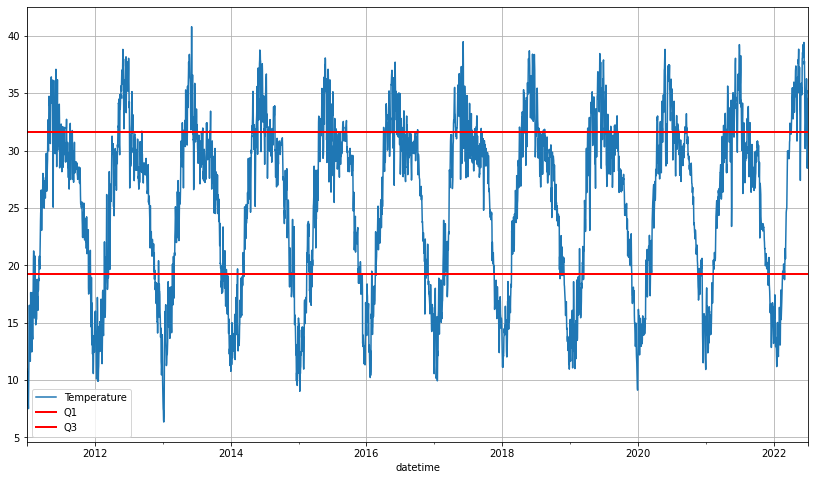

In [ ]:
"""
Plotting mean temperature over dates

"""


fig, ax = plt.subplots(1, figsize=(14, 8))

weather.set_index('datetime').resample('D').temperature.mean().plot(ax=ax, label='Temperature')
plt.axhline(weather.temperature.quantile(0.25), color='r', linewidth=2, label='Q1')
plt.axhline(weather.temperature.quantile(0.75), color='r', linewidth=2, label='Q3')
plt.grid('on')
plt.legend()
plt.plot()

The plot looks seasonal

In [ ]:
# Checking for outliers

for i in weather.columns[1:]:
  Q1 = weather[i].quantile(0.25)
  Q3 = weather[i].quantile(0.75)
  IQR = Q3 - Q1

  low = Q1 - 1.5 * IQR
  high = Q3 + 1.5 * IQR

  print(i, weather[(weather[i] < low) | (weather[i] > high)].shape)

apparent_temperature (0, 7)
temperature (0, 7)
humidity (0, 7)
dew_point (1692, 7)
wind_speed (6267, 7)
cloud_cover (0, 7)


Outlier seems to be seen only for dew_point and wind_speed

In [ ]:
# Checking for outliers for dew_point and wind_speed

for i in ['dew_point', 'wind_speed']:
  Q1 = weather[i].quantile(0.25)
  Q3 = weather[i].quantile(0.75)
  IQR = Q3 - Q1

  low = Q1 - 1.5 * IQR
  high = Q3 + 1.5 * IQR
  print(f'\n\n{i}')
  print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, low: {low}, high: {high}')
  print(f'Below low: {weather[weather[i] < low].shape}')
  print(f'Above high: {weather[weather[i] > high].shape}')

  print(i, weather[(weather[i] < low) | (weather[i] > high)].shape)



dew_point
Q1: 9.49, Q3: 22.627499999999998, IQR: 13.137499999999998, low: -10.216249999999997, high: 42.333749999999995
Below low: (1692, 7)
Above high: (0, 7)
dew_point (1692, 7)


wind_speed
Q1: 1.3725, Q3: 3.145, IQR: 1.7725, low: -1.28625, high: 5.80375
Below low: (0, 7)
Above high: (6267, 7)
wind_speed (6267, 7)


So, we can see that dew_points shows outliers for value only below low range

And

wind_speedshows outliers for value only above high range

**Same things can be observed by box plots plotted below**

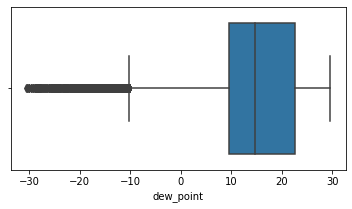

In [ ]:
# Box plot for dew_point

plt.figure(figsize=(6,3))
sns.boxplot(weather.dew_point)

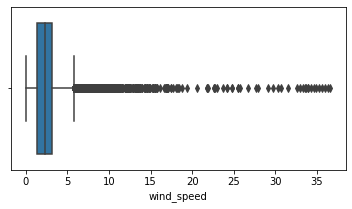

In [ ]:
# Box plot for wind_speed

plt.figure(figsize=(6,3))
sns.boxplot(weather.wind_speed)

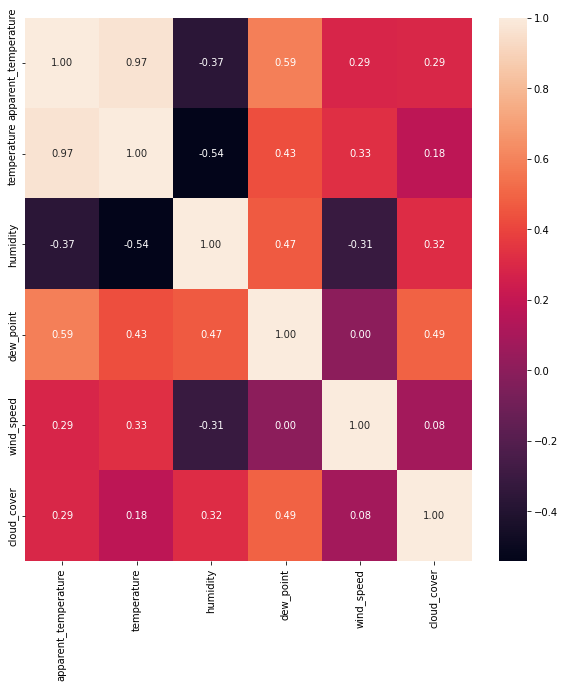

In [ ]:
plt.figure(figsize=(10, 10))
cor = weather[weather.columns[1:]].corr()
sns.heatmap(cor, annot=True, fmt='.2f')

From the heatmap, it can be seen that wind_speed and dew_points are importants factors.

So, we will replace dew_points with low value during outlier detection
and, wind_speed with high value assuming too low dew_points and too_high wind_speed data is incorrect.

In [ ]:
"""

Outlier replacement dew_point and wind_speed

As observed above,
  for dew_points, all outliers are below low range
  and
  for wind_speed, all outliers are above high range

  Assuming these data are incorrrect,
  we will replace dew_points with low value during outlier detection and, wind_speed with high value
"""

for i in ['dew_point', 'wind_speed']:
  Q1 = weather[i].quantile(0.25)
  Q3 = weather[i].quantile(0.75)
  IQR = Q3 - Q1

  low = Q1 - 1.5 * IQR
  high = Q3 + 1.5 * IQR
  print(f'\n\n{i}')
  print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, low: {low}, high: {high}')

  print(f'Below low: {weather[weather[i] < low].shape}')
  print(f'Above high: {weather[weather[i] > high].shape}')

  if i == 'dew_point':
    print('Replacing value below low with', low)
    weather.loc[weather['dew_point'] < low, 'dew_point'] = low
  elif i == 'wind_speed':
    print('Replacing value above with', high)
    weather.loc[weather.wind_speed > high, 'wind_speed'] = high

  print(f'Below low: {weather[weather[i] < low].shape}')
  print(f'Above high: {weather[weather[i] > high].shape}')

  print(i, weather[(weather[i] < low) | (weather[i] > high)].shape)



dew_point
Q1: 9.49, Q3: 22.627499999999998, IQR: 13.137499999999998, low: -10.216249999999997, high: 42.333749999999995
Below low: (1692, 7)
Above high: (0, 7)
Replacing value below low with -10.216249999999997
Below low: (0, 7)
Above high: (0, 7)
dew_point (0, 7)


wind_speed
Q1: 1.3725, Q3: 3.145, IQR: 1.7725, low: -1.28625, high: 5.80375
Below low: (0, 7)
Above high: (6267, 7)
Replacing value above with 5.80375
Below low: (0, 7)
Above high: (0, 7)
wind_speed (0, 7)


In [ ]:
# Again Checking for outliers

# Checking for outliers

for i in weather.columns[1:]:
  Q1 = weather[i].quantile(0.25)
  Q3 = weather[i].quantile(0.75)
  IQR = Q3 - Q1

  low = Q1 - 1.5 * IQR
  high = Q3 + 1.5 * IQR

  print(i, weather[(weather[i] < low) | (weather[i] > high)].shape)

apparent_temperature (0, 7)
temperature (0, 7)
humidity (0, 7)
dew_point (0, 7)
wind_speed (0, 7)
cloud_cover (0, 7)


Now we have no outliers in weather data

## Creating Additional features

In [ ]:
"""
Taking features from last practice assignment
"""


weather['temp_mean_1h'] = weather['temperature'].ewm(span=4).mean()
weather['temp_mean_3h'] = weather['temperature'].ewm(span=12).mean()
weather['temp_mean_6h'] = weather['temperature'].ewm(span=24).mean()
weather['temp_mean_9h'] = weather['temperature'].ewm(span=36).mean()
weather['temp_mean_12h'] = weather['temperature'].ewm(span=48).mean()
weather['aptemp_mean_1h'] = weather['apparent_temperature'].ewm(span=4).mean()
weather['aptemp_mean_3h'] = weather['apparent_temperature'].ewm(span=12).mean() 
weather['aptemp_mean_5h'] = weather['apparent_temperature'].ewm(span=24).mean() 
weather['aptemp_mean_6h'] = weather['apparent_temperature'].ewm(span=36).mean()
weather['aptemp_mean_9h'] = weather['apparent_temperature'].ewm(span=36).mean()
weather['aptemp_mean_12h'] = weather['apparent_temperature'].ewm(span=48).mean()
weather['dew_point_mean_1h'] = weather['dew_point'].ewm(span=4).mean()
weather['dew_point_mean_2h'] = weather['dew_point'].ewm(span=8).mean()
weather['dew_point_mean_3h'] = weather['dew_point'].ewm(span=12).mean()
weather['humidity_mean_1h'] = weather['humidity'].ewm(span=4).mean()
weather['humidity_mean_2h'] = weather['humidity'].ewm(span=8).mean()
weather['humidity_mean_3h'] = weather['humidity'].ewm(span=12).mean()
weather['wind_speed_1h'] = weather['wind_speed'].ewm(span=4).mean()
weather['wind_speed_2h'] = weather['wind_speed'].ewm(span=8).mean()
weather['wind_speed_5h'] = weather['wind_speed'].ewm(span=20).mean()
weather.head()

,datetime,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,temp_mean_1h,temp_mean_3h,temp_mean_6h,...,aptemp_mean_12h,dew_point_mean_1h,dew_point_mean_2h,dew_point_mean_3h,humidity_mean_1h,humidity_mean_2h,humidity_mean_3h,wind_speed_1h,wind_speed_2h,wind_speed_5h
0,2011-01-01 00:00:00,8.4400,9.6800,0.9500,8.950,2.5100,0.3000,9.680000,9.680000,9.680000,...,8.440000,8.950000,8.950000,8.950000,0.950000,0.950000,0.950000,2.510000,2.510000,2.510000
1,2011-01-01 00:15:00,8.2575,9.4825,0.9625,8.935,2.4425,0.3025,9.556563,9.573021,9.577135,...,8.346849,8.940625,8.941562,8.941875,0.957812,0.957031,0.956771,2.467812,2.472031,2.474563
2,2011-01-01 00:30:00,8.0750,9.2850,0.9750,8.920,2.3750,0.3050,9.418010,9.460606,9.471534,...,8.252431,8.930102,8.932513,8.933337,0.966582,0.964573,0.963886,2.420459,2.431308,2.438004
3,2011-01-01 00:45:00,7.8925,9.0875,0.9875,8.905,2.3075,0.3075,9.266121,9.342831,9.363206,...,8.156748,8.918566,8.922870,8.924392,0.976195,0.972608,0.971340,2.368548,2.387916,2.400329
4,2011-01-01 01:00:00,7.7100,8.8900,1.0000,8.890,2.2400,0.3100,9.102988,9.219799,9.252163,...,8.059801,8.906176,8.912659,8.915048,0.986520,0.981117,0.979127,2.312793,2.341967,2.361547


In [ ]:
# Checking for nan values in weather dataframe

weather.isna().sum()[weather.isna().sum() > 0]

Series([], dtype: int64)

In [ ]:
df2.shape, weather.shape

((394464, 64), (403584, 27))

In [ ]:
# Merging load and weather dataframes

df = pd.merge(df2, weather, how='left', on='datetime')
print(df.shape)
df.head()

(394464, 90)


,datetime,date,tb,load,IQR_OUTLIER,year,month,hour,dow,doy,...,aptemp_mean_12h,dew_point_mean_1h,dew_point_mean_2h,dew_point_mean_3h,humidity_mean_1h,humidity_mean_2h,humidity_mean_3h,wind_speed_1h,wind_speed_2h,wind_speed_5h
0,2011-04-01 00:00:00,2011-04-01,1,NaN,False,2011,4,0,4,91,...,27.623132,13.938979,13.673886,13.367249,0.503986,0.487819,0.469043,3.581896,3.628672,3.721261
1,2011-04-01 00:15:00,2011-04-01,2,NaN,False,2011,4,0,4,91,...,27.500453,13.860388,13.689134,13.424980,0.505392,0.492193,0.474960,3.441137,3.540078,3.674474
2,2011-04-01 00:30:00,2011-04-01,3,NaN,False,2011,4,0,4,91,...,27.372884,13.690233,13.632659,13.426522,0.505235,0.495039,0.479581,3.224682,3.397839,3.600714
3,2011-04-01 00:45:00,2011-04-01,4,NaN,False,2011,4,0,4,91,...,27.240623,13.465140,13.520402,13.380518,0.504141,0.496697,0.483107,2.962809,3.213874,3.502551
4,2011-04-01 01:00:00,2011-04-01,5,NaN,False,2011,4,1,4,91,...,27.103863,13.207084,13.364757,13.294285,0.502485,0.497431,0.485706,2.673686,2.997458,3.382308


In [ ]:
df.isna().sum()[df.isna().sum() > 0]

load              22464
load_wm_1.0_h        96
load_wm_2.0_h        96
load_wm_3.0_h        96
load_wm_6.0_h        96
load_wm_12.0_h       96
load_wm_24.0_h       96
ramp1             22683
ramp2             22684
ramp3             22685
ramp4             22686
hour_mean         22464
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394464 entries, 0 to 394463
Data columns (total 90 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   datetime              394464 non-null  datetime64[ns]
 1   date                  394464 non-null  object        
 2   tb                    394464 non-null  int64         
 3   load                  372000 non-null  float64       
 4   IQR_OUTLIER           394464 non-null  bool          
 5   year                  394464 non-null  int64         
 6   month                 394464 non-null  int64         
 7   hour                  394464 non-null  int64         
 8   dow                   394464 non-null  int64         
 9   doy                   394464 non-null  int64         
 10  week                  394464 non-null  int64         
 11  isMorning             394464 non-null  int64         
 12  isAfternoon           394464 non-null  int64         
 13 

In [ ]:
# Removing irrelevant rows

df = df.drop(columns=['IQR_OUTLIER'])
df.shape

(394464, 89)

## EDA of weather data

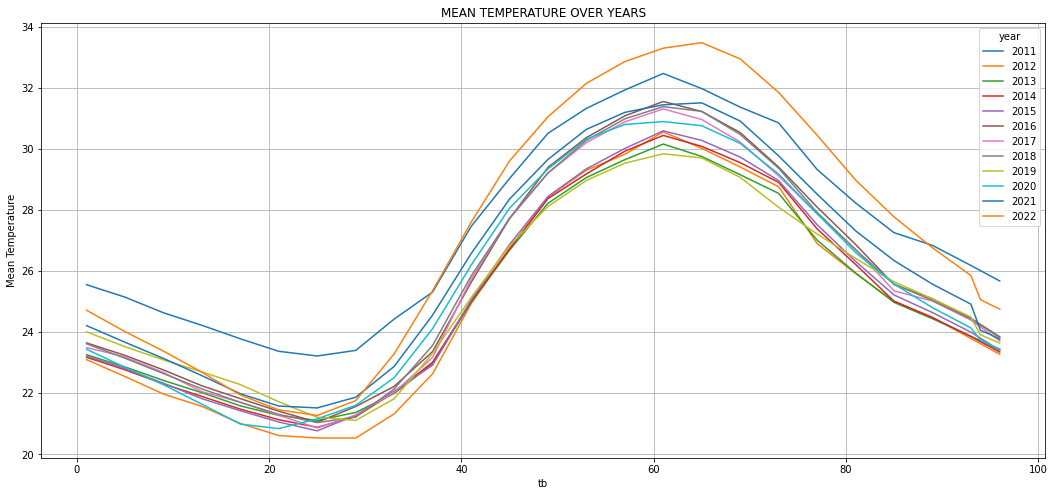

In [ ]:
"""
Plotting mean temperature over years
"""

df.set_index('datetime').groupby(['year', 'tb']).temperature.mean().unstack().T.plot()
plt.ylabel('Mean Temperature')
plt.title('MEAN TEMPERATURE OVER YEARS')
plt.grid('on')
plt.show()

All years have almost same pattern of temperature mean

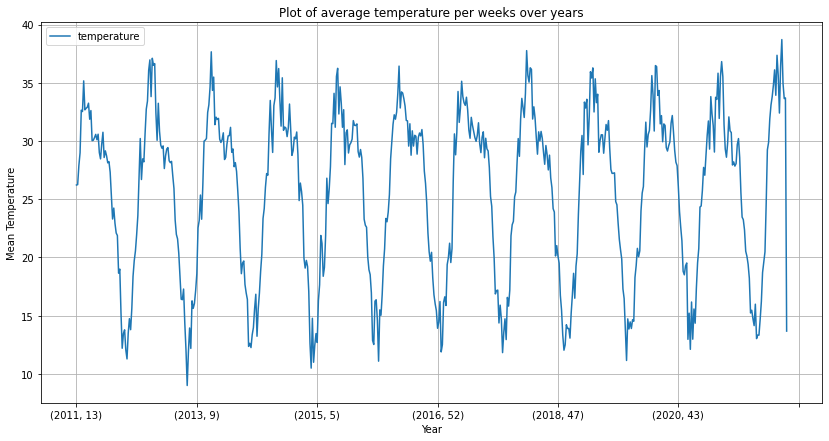

In [ ]:
"""
Plotting mean temperature over Weeks for each year

"""

fig, ax = plt.subplots(1, figsize=(14, 7))

df.groupby(['year', 'week']).temperature.mean().plot(ax = ax)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature')
ax.set_title('Plot of average temperature per weeks over years')

plt.grid('on')
plt.show()

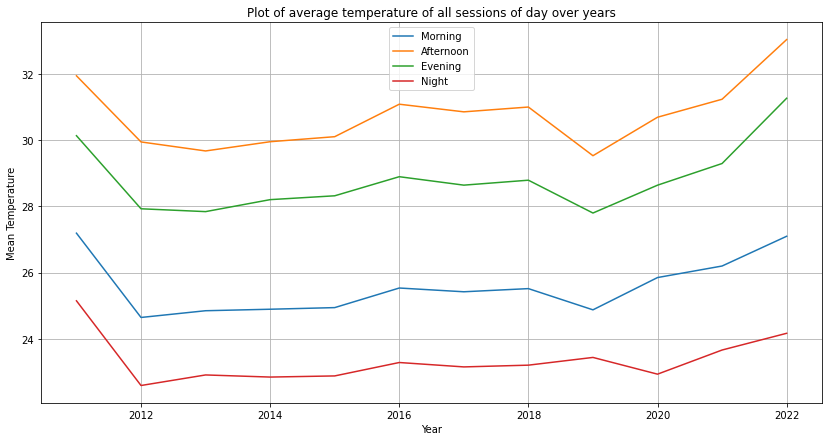

In [ ]:
"""
Plotting day sessions temperatures

"""

fig, ax = plt.subplots(1, figsize=(14, 7))

df[df.isMorning == 1].groupby('year').temperature.mean().plot(ax=ax, label='Morning')
df[df.isAfternoon == 1].groupby('year').temperature.mean().plot(ax=ax, label='Afternoon')
df[df.isEvening == 1].groupby('year').temperature.mean().plot(ax=ax, label='Evening')
df[df.isNight == 1].groupby('year').temperature.mean().plot(ax=ax, label='Night')

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature')
ax.set_title('Plot of average temperature of all sessions of day over years')

plt.grid('on')
plt.show()

As expected, afternoon has max temp followed by evening, then morning and night has the lowest

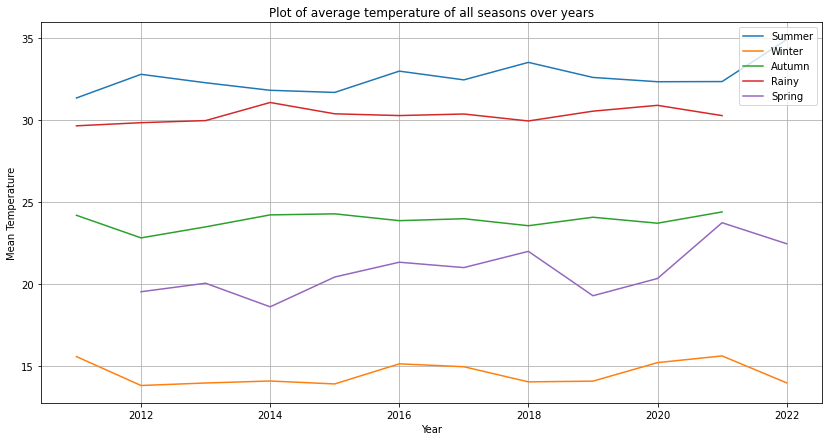

In [ ]:
"""
Plotting Seasonal temperatures

"""

fig, ax = plt.subplots(1, figsize=(14, 7))

df[df.is_summer == 1].groupby('year').temperature.mean().plot(ax=ax, label='Summer')
df[df.is_winter == 1].groupby('year').temperature.mean().plot(ax=ax, label='Winter')
df[df.is_autumn == 1].groupby('year').temperature.mean().plot(ax=ax, label='Autumn')
df[df.is_rainy == 1].groupby('year').temperature.mean().plot(ax=ax, label='Rainy')
df[df.is_spring == 1].groupby('year').temperature.mean().plot(ax=ax, label='Spring')

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature')
ax.set_title('Plot of average temperature of all seasons over years')

plt.grid('on')
plt.show()

Summer has max temperatures and winter with the lowest

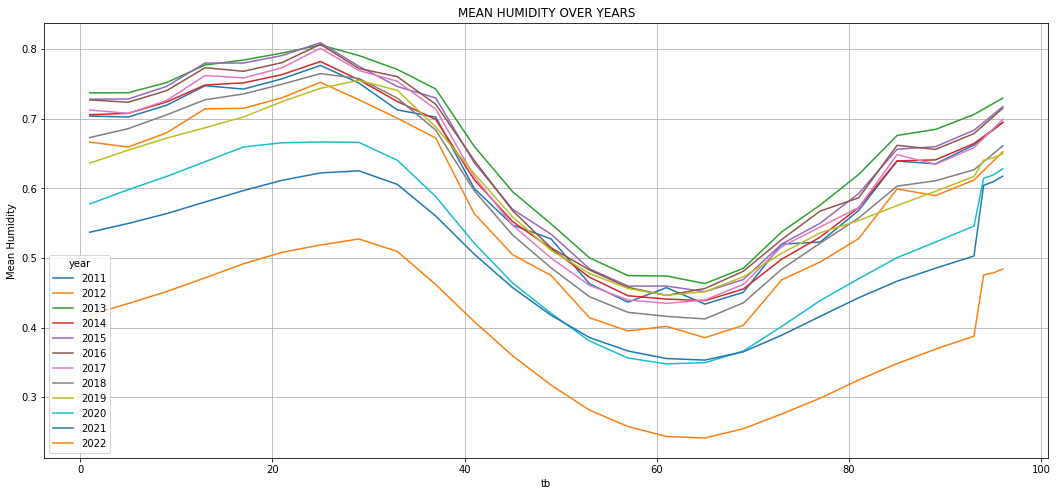

In [ ]:
"""
Plotting mean Humidity over years
"""

df.set_index('datetime').groupby(['year', 'tb']).humidity.mean().unstack().T.plot()
plt.ylabel('Mean Humidity')
plt.title('MEAN HUMIDITY OVER YEARS')
plt.grid('on')
plt.show()

As observed, humidity is minimum during evenings and max during afternoon

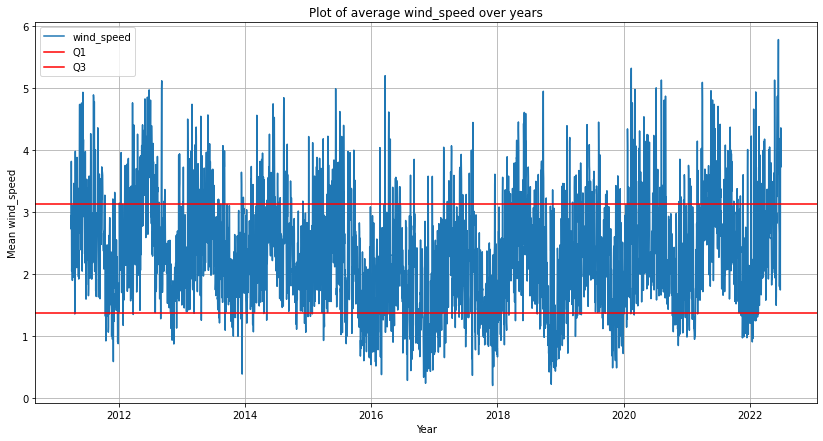

In [ ]:
"""
Plotting mean wind_speed over dates

"""

fig, ax = plt.subplots(1, figsize=(14, 7))

df.groupby('date').wind_speed.mean().plot(ax = ax)
ax.axhline(df.wind_speed.quantile(0.25), color='r', label='Q1')
ax.axhline(df.wind_speed.quantile(0.75), color='r', label='Q3')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Mean wind_speed')
ax.set_title('Plot of average wind_speed over years')

plt.grid('on')
plt.show()

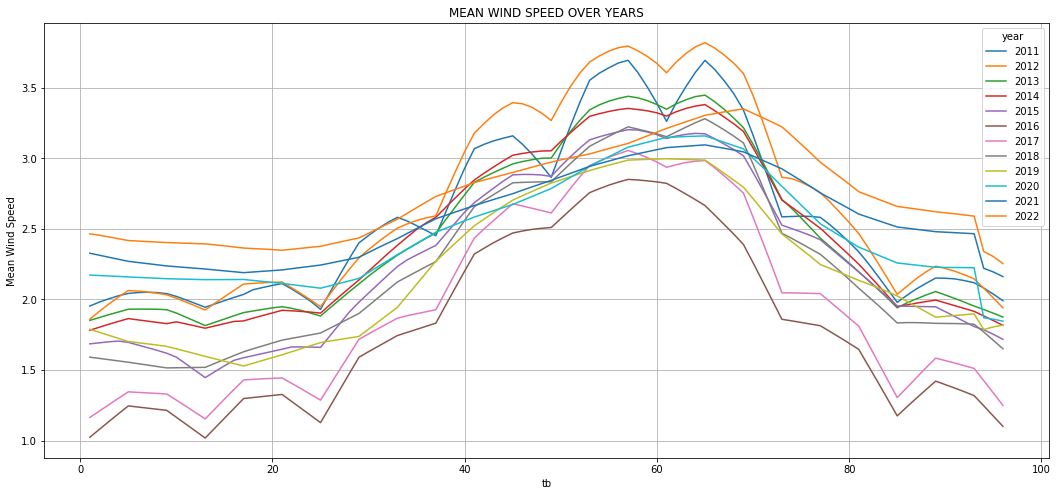

In [ ]:
"""
Plotting mean wind_speed over years
"""

df.set_index('datetime').groupby(['year', 'tb']).wind_speed.mean().unstack().T.plot()
plt.ylabel('Mean Wind Speed')
plt.title('MEAN WIND SPEED OVER YEARS')
plt.grid('on')
plt.show()

Wind speed is at peak during evenings

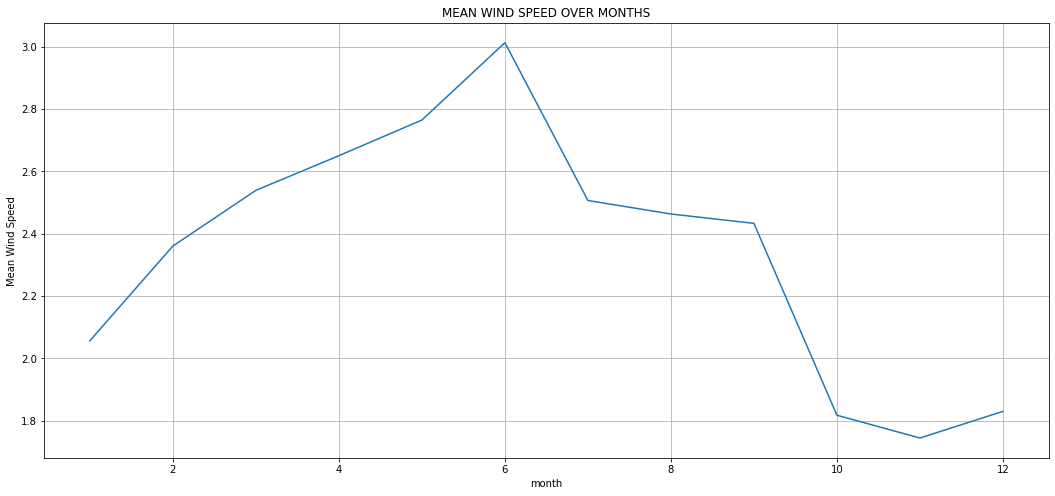

In [ ]:
"""
Plotting mean wind_speed over months

"""

df.set_index('datetime').groupby(['month']).wind_speed.mean().plot()
plt.ylabel('Mean Wind Speed')
plt.title('MEAN WIND SPEED OVER MONTHS')
plt.grid('on')
plt.show()

Wind speed is max during evening and during the month of june (maybe early monsoon)

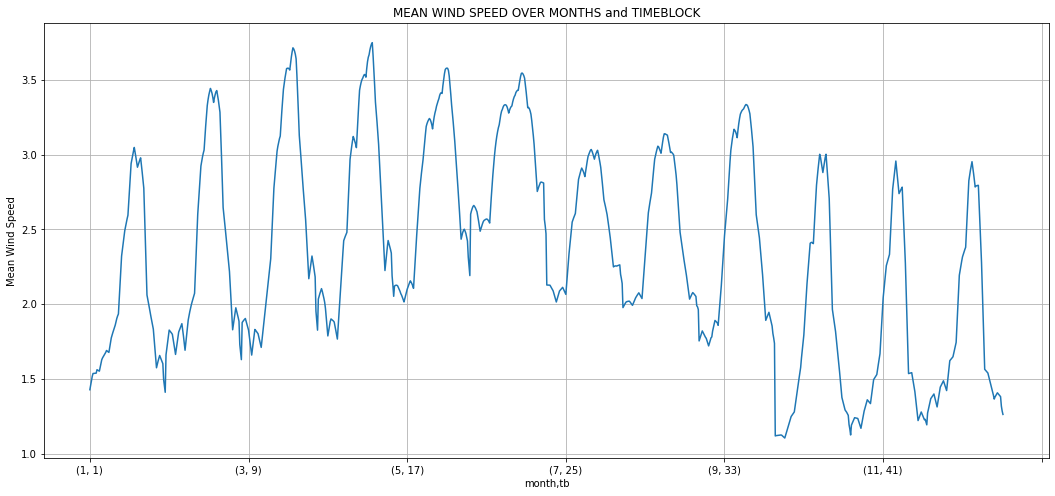

In [ ]:
"""
Plotting mean wind_speed over months and timeblock

"""

df.set_index('datetime').groupby(['month', 'tb']).wind_speed.mean().plot()
plt.ylabel('Mean Wind Speed')
plt.title('MEAN WIND SPEED OVER MONTHS and TIMEBLOCK')
plt.grid('on')
plt.show()

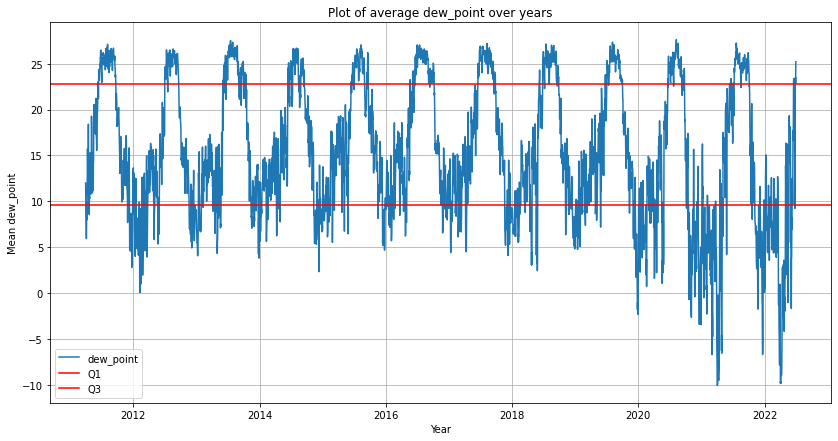

In [ ]:
"""
Plotting mean dew_point over dates

"""

fig, ax = plt.subplots(1, figsize=(14, 7))

df.groupby('date').dew_point.mean().plot(ax = ax)
ax.axhline(df.dew_point.quantile(0.25), color='r', label='Q1')
ax.axhline(df.dew_point.quantile(0.75), color='r', label='Q3')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Mean dew_point')
ax.set_title('Plot of average dew_point over years')

plt.grid('on')
plt.show()

Dew point also shows seasonal trends over years

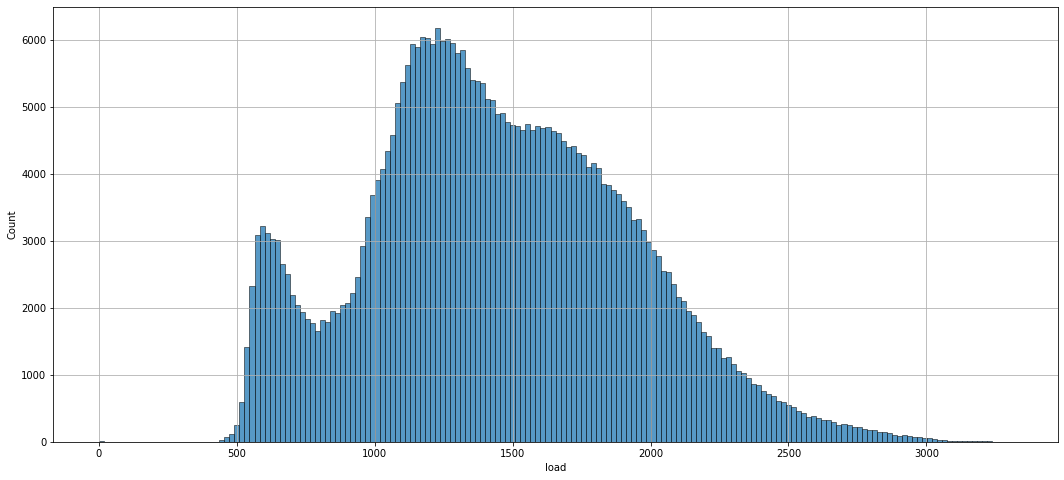

In [ ]:
"""
Load histogram plot
"""

sns.histplot(df.load)

plt.grid('on')
plt.show()

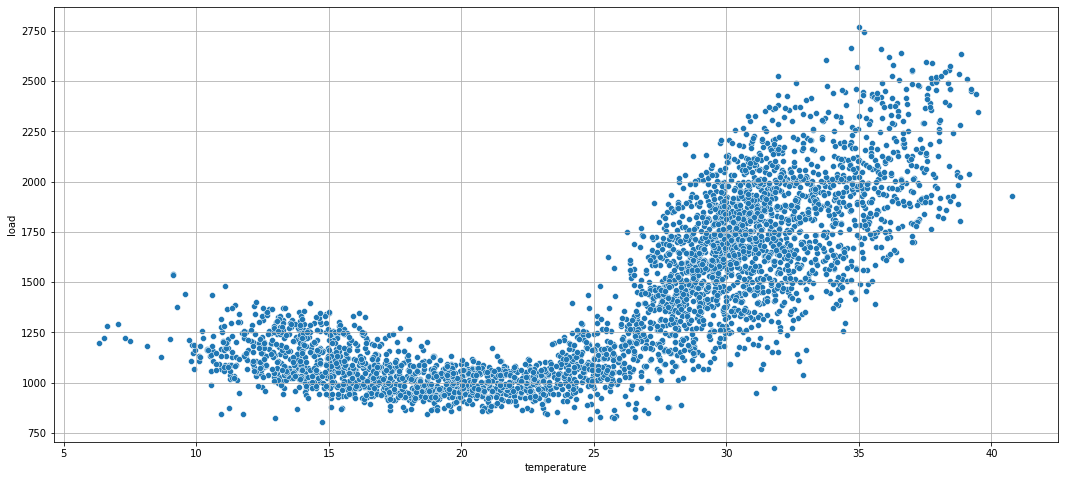

In [ ]:
"""
Plotting load with temperature
"""

sns.scatterplot(df.groupby('date').temperature.mean(), df.groupby('date').load.mean())

plt.grid('on')
plt.show()

A trend of increasing load with temperature is observed

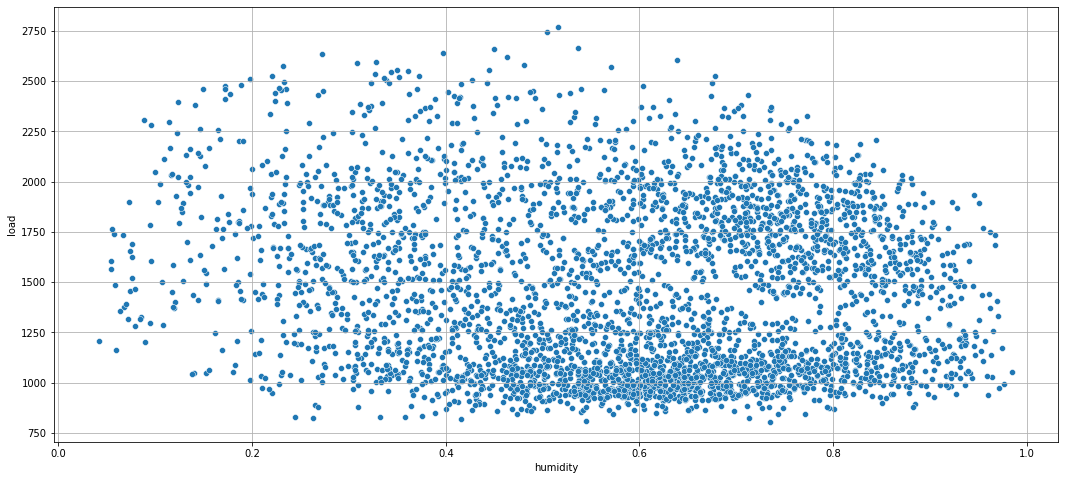

In [ ]:
"""
Plotting humidity with respect to load
"""

sns.scatterplot(df.groupby('date').humidity.mean(), df.groupby('date').load.mean())

plt.grid('on')
plt.show()

In [ ]:
df.head()

,datetime,date,tb,load,year,month,hour,dow,doy,week,...,aptemp_mean_12h,dew_point_mean_1h,dew_point_mean_2h,dew_point_mean_3h,humidity_mean_1h,humidity_mean_2h,humidity_mean_3h,wind_speed_1h,wind_speed_2h,wind_speed_5h
0,2011-04-01 00:00:00,2011-04-01,1,NaN,2011,4,0,4,91,13,...,27.623132,13.938979,13.673886,13.367249,0.503986,0.487819,0.469043,3.581896,3.628672,3.721261
1,2011-04-01 00:15:00,2011-04-01,2,NaN,2011,4,0,4,91,13,...,27.500453,13.860388,13.689134,13.424980,0.505392,0.492193,0.474960,3.441137,3.540078,3.674474
2,2011-04-01 00:30:00,2011-04-01,3,NaN,2011,4,0,4,91,13,...,27.372884,13.690233,13.632659,13.426522,0.505235,0.495039,0.479581,3.224682,3.397839,3.600714
3,2011-04-01 00:45:00,2011-04-01,4,NaN,2011,4,0,4,91,13,...,27.240623,13.465140,13.520402,13.380518,0.504141,0.496697,0.483107,2.962809,3.213874,3.502551
4,2011-04-01 01:00:00,2011-04-01,5,NaN,2011,4,1,4,91,13,...,27.103863,13.207084,13.364757,13.294285,0.502485,0.497431,0.485706,2.673686,2.997458,3.382308


**Now the data is ready**

## Modelling the data

In [ ]:
cols = df.columns
cols

Index(['datetime', 'date', 'tb', 'load', 'year', 'month', 'hour', 'dow', 'doy',
       'week', 'isMorning', 'isAfternoon', 'isEvening', 'isNight', 'is_summer',
       'is_rainy', 'is_autumn', 'is_winter', 'is_spring', 'cos_tb', 'sin_tb',
       'cos_hour', 'sin_hour', 'cos_dow', 'sin_dow', 'cos_doy', 'sin_doy',
       'load_lag_1', 'load_lag_2', 'load_lag_3', 'load_lag_4', 'load_lag_8',
       'load_lag_96', 'load_lag_192', 'load_rolling_mean_4',
       'load_rolling_max_4', 'load_rolling_min_4', 'load_rolling_mean_8',
       'load_rolling_max_8', 'load_rolling_min_8', 'load_rolling_mean_12',
       'load_rolling_max_12', 'load_rolling_min_12', 'load_rolling_mean_24',
       'load_rolling_max_24', 'load_rolling_min_24', 'load_rolling_mean_48',
       'load_rolling_max_48', 'load_rolling_min_48', 'load_rolling_mean_96',
       'load_rolling_max_96', 'load_rolling_min_96', 'load_wm_1.0_h',
       'load_wm_2.0_h', 'load_wm_3.0_h', 'load_wm_6.0_h', 'load_wm_12.0_h',
       'load_wm_24.0_h'

In [ ]:
"""
Making final df

With ramp having shift of 192 timeblocks
and removing irrelevant feature like date
"""

final_df = pd.DataFrame()
target = 192

df['ramp'] = df['load'].shift(target)
final_df = df.drop(columns=['date'])
final_df = final_df.set_index('datetime')
final_df

,tb,load,year,month,hour,dow,doy,week,isMorning,isAfternoon,...,dew_point_mean_1h,dew_point_mean_2h,dew_point_mean_3h,humidity_mean_1h,humidity_mean_2h,humidity_mean_3h,wind_speed_1h,wind_speed_2h,wind_speed_5h,ramp
datetime,,,,,,,,,,,,,,,,,,,,,
2011-04-01 00:00:00,1,NaN,2011,4,0,4,91,13,0,0,...,13.938979,13.673886,13.367249,0.503986,0.487819,0.469043,3.581896,3.628672,3.721261,NaN
2011-04-01 00:15:00,2,NaN,2011,4,0,4,91,13,0,0,...,13.860388,13.689134,13.424980,0.505392,0.492193,0.474960,3.441137,3.540078,3.674474,NaN
2011-04-01 00:30:00,3,NaN,2011,4,0,4,91,13,0,0,...,13.690233,13.632659,13.426522,0.505235,0.495039,0.479581,3.224682,3.397839,3.600714,NaN
2011-04-01 00:45:00,4,NaN,2011,4,0,4,91,13,0,0,...,13.465140,13.520402,13.380518,0.504141,0.496697,0.483107,2.962809,3.213874,3.502551,NaN
2011-04-01 01:00:00,5,NaN,2011,4,1,4,91,13,0,0,...,13.207084,13.364757,13.294285,0.502485,0.497431,0.485706,2.673686,2.997458,3.382308,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 22:45:00,92,2260.0,2022,6,22,3,181,26,0,0,...,24.146973,24.078324,24.070376,0.806806,0.796104,0.788716,2.776332,2.852656,2.854968,3311.0
2022-06-30 23:00:00,93,2272.0,2022,6,23,3,181,26,0,0,...,24.204184,24.125363,24.104164,0.808084,0.799192,0.791990,2.665799,2.774288,2.821162,3298.0
2022-06-30 23:15:00,94,2274.0,2022,6,23,3,181,26,0,0,...,24.522510,24.319727,24.241985,0.816850,0.806038,0.797838,2.727480,2.784446,2.821051,3245.0


In [ ]:
""" 
Setting target variable as 2 day ahead forecast
Means, shifting load to -192 timeblocks and making it as target variable

"""

final_df['target'] = final_df['load'].shift(-192)
final_df.head()

,tb,load,year,month,hour,dow,doy,week,isMorning,isAfternoon,...,dew_point_mean_2h,dew_point_mean_3h,humidity_mean_1h,humidity_mean_2h,humidity_mean_3h,wind_speed_1h,wind_speed_2h,wind_speed_5h,ramp,target
datetime,,,,,,,,,,,,,,,,,,,,,
2011-04-01 00:00:00,1,NaN,2011,4,0,4,91,13,0,0,...,13.673886,13.367249,0.503986,0.487819,0.469043,3.581896,3.628672,3.721261,NaN,932.092
2011-04-01 00:15:00,2,NaN,2011,4,0,4,91,13,0,0,...,13.689134,13.424980,0.505392,0.492193,0.474960,3.441137,3.540078,3.674474,NaN,909.508
2011-04-01 00:30:00,3,NaN,2011,4,0,4,91,13,0,0,...,13.632659,13.426522,0.505235,0.495039,0.479581,3.224682,3.397839,3.600714,NaN,890.788
2011-04-01 00:45:00,4,NaN,2011,4,0,4,91,13,0,0,...,13.520402,13.380518,0.504141,0.496697,0.483107,2.962809,3.213874,3.502551,NaN,878.820
2011-04-01 01:00:00,5,NaN,2011,4,1,4,91,13,0,0,...,13.364757,13.294285,0.502485,0.497431,0.485706,2.673686,2.997458,3.382308,NaN,868.216


In [ ]:
print(final_df.shape)
final_df.isna().sum()[final_df.isna().sum() > 0]

(394464, 89)


load              22464
load_wm_1.0_h        96
load_wm_2.0_h        96
load_wm_3.0_h        96
load_wm_6.0_h        96
load_wm_12.0_h       96
load_wm_24.0_h       96
ramp1             22683
ramp2             22684
ramp3             22685
ramp4             22686
hour_mean         22464
ramp              22656
target            22560
dtype: int64

Deleting around 22000 rows having nan values, since that will not affect our big size (~394000) data

In [ ]:
"""
Using dropna to drop nan values
"""

final_df.dropna(inplace=True)
final_df = final_df.reset_index()
print(final_df.shape)
final_df.head()

(331004, 90)


,datetime,tb,load,year,month,hour,dow,doy,week,isMorning,...,dew_point_mean_2h,dew_point_mean_3h,humidity_mean_1h,humidity_mean_2h,humidity_mean_3h,wind_speed_1h,wind_speed_2h,wind_speed_5h,ramp,target
0,2011-04-04 00:00:00,1,874.808,2011,4,0,0,94,14,0,...,7.676243,7.593486,0.346081,0.332919,0.323388,3.070872,3.334763,3.498157,933.476,915.165
1,2011-04-04 00:15:00,2,852.348,2011,4,0,0,94,14,0,...,7.739300,7.649873,0.349648,0.337826,0.328252,3.030523,3.253705,3.447856,917.484,901.228
2,2011-04-04 00:30:00,3,838.044,2011,4,0,0,94,14,0,...,7.721678,7.651431,0.349789,0.340531,0.331597,3.146314,3.268437,3.435679,904.468,885.772
3,2011-04-04 00:45:00,4,827.100,2011,4,0,0,94,14,0,...,7.641305,7.606595,0.347873,0.341524,0.333659,3.355788,3.357673,3.457996,890.156,872.256
4,2011-04-04 01:00:00,5,817.984,2011,4,1,0,94,14,0,...,7.512126,7.522504,0.344724,0.341186,0.334635,3.621473,3.504857,3.511520,881.604,864.396


In [ ]:
(63460 / 394464)*100

16.087653119169303

This method of dropping nan values drops about 63000 rows (16%) of data

Lets work with this, and see if that works

In [ ]:
"""
Train-test-validation split

Using 

val_cutoff = '2021-03-01'
test_cutoff = '2022-04-01'

as cutoffs
"""

val_cutoff = '2021-03-01'
test_cutoff = '2022-04-01'

X = final_df.drop('target', axis=1).copy()
y = final_df[['datetime', 'target']].copy()

X_train = X[X.datetime < val_cutoff + ' 00:00:00'].iloc[:, 1:].copy()
y_train = y[y.datetime < val_cutoff + ' 00:00:00'].iloc[:, 1:].copy()

X_val = X[(X.datetime >= val_cutoff + ' 00:00:00') & (X.datetime < test_cutoff + ' 00:00:00')].iloc[:, 1:].copy()
y_val = y[(y.datetime >= val_cutoff + ' 00:00:00') & (y.datetime < test_cutoff + ' 00:00:00')].iloc[:, 1:].copy()

X_test = X[X.datetime >= test_cutoff + ' 00:00:00'].iloc[:, 1:].copy()
y_test = y[y.datetime >= test_cutoff + ' 00:00:00'].iloc[:, 1:].copy()

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(290080, 88) (290080, 1)
(32380, 88) (32380, 1)
(8544, 88) (8544, 1)


### Feature Scaling

Using standard scaling

In [ ]:
"""
Using Standard Scaling for scaling of dataset

StandardScaling = (X - mean(X)) / stdandard_deviation(X)
using StandardScaler from sklearn.preprocessing for this task
"""


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
x_val = pd.DataFrame(scaler.fit_transform(X_val), index=X_val.index, columns=X_val.columns)
x_test = pd.DataFrame(scaler.fit_transform(X_test), index=X_test.index, columns=X_test.columns)

x_train.head()

,tb,load,year,month,hour,dow,doy,week,isMorning,isAfternoon,...,dew_point_mean_1h,dew_point_mean_2h,dew_point_mean_3h,humidity_mean_1h,humidity_mean_2h,humidity_mean_3h,wind_speed_1h,wind_speed_2h,wind_speed_5h,ramp
0,-1.721819,-1.208193,-1.639364,-0.706841,-1.668938,-1.494179,-0.821156,-0.812624,-0.578284,-0.447865,...,-1.103471,-1.137415,-1.151462,-1.160018,-1.233001,-1.294946,0.574584,0.802576,1.020539,-1.079209
1,-1.685656,-1.256052,-1.639364,-0.706841,-1.668938,-1.494179,-0.821156,-0.812624,-0.578284,-0.447865,...,-1.100247,-1.128738,-1.143685,-1.144203,-1.210992,-1.272808,0.543472,0.738122,0.976789,-1.113263
2,-1.649492,-1.286531,-1.639364,-0.706841,-1.668938,-1.494179,-0.821156,-0.812624,-0.578284,-0.447865,...,-1.114780,-1.131163,-1.143470,-1.143580,-1.198858,-1.257577,0.632756,0.749836,0.966198,-1.140980
3,-1.613328,-1.309850,-1.639364,-0.706841,-1.668938,-1.494179,-0.821156,-0.812624,-0.578284,-0.447865,...,-1.139966,-1.142222,-1.149654,-1.152071,-1.194404,-1.248191,0.794279,0.820794,0.985608,-1.171457
4,-1.577164,-1.329275,-1.639364,-0.706841,-1.524165,-1.494179,-0.821156,-0.812624,-0.578284,-0.447865,...,-1.171545,-1.159997,-1.161252,-1.166030,-1.195923,-1.243750,0.999144,0.937829,1.032161,-1.189668


### Feature Selection

Selecting the best features, lets try:
- Variance Inflaction Factor (VIF)
- RandomForest

In [ ]:
# Using VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

# def calculate_vif(df):
#     vif = pd.DataFrame()
#     vif['Feature'] = df.columns
#     vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
#     return (vif)

# vif_table = calculate_vif(x_train)
# vif_table = vif_table.VIF.sort_values(ascending=False)
# vif_table

In [ ]:
"""
Checking if these top fetures performs well
"""



'\nChecking if these top fetures performs well\n'

In [ ]:
"""
Importing RandomForestRegressor from sklearn.ensemble

Then fitting and getting best features based on feature_importances_

"""

from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
model = XGBRegressor()
rfe = RFE(estimator = model, n_features_to_select = 20).fit(X_train, y_train)
# Top 15 features
print("Top 15 features: ", list(X_train.columns[rfe.support_]))

[17:30:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:34:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:38:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:40:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:42:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# Adding sin cos transformed time indicators for the model to catch seasonality
rfe_features = list(X_train.columns[rfe.support_]) + ['cos_hour', 'sin_hour', 'cos_doy', 'sin_doy']

from sklearn.linear_model import RidgeCV
reg = RidgeCV(alphas=(0.1, 1, 10),scoring='neg_mean_squared_error',cv=5)
reg.fit(X_train[rfe_features], y_train)
print(reg.score(X_train[rfe_features], y_train))

0.9174828488261543


So, 91.7 is the score

In [ ]:
# Making the final predictions
pred_train = reg.predict(X_train[rfe_features])
pred_valid = reg.predict(X_val[rfe_features])
pred_test = reg.predict(X_test[rfe_features])

In [ ]:
# Evaluate model accuracy 
# Using mse, rmse and mae

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(f"Train MSE: {mean_squared_error(y_train['target'],pred_train)}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train['target'],pred_train))}")
print(f"Train MAE: {mean_absolute_error(y_train['target'],pred_train)}")
print(f'Train r2-score: {r2_score(y_train, pred_train)}')

print(f"valid MSE: {mean_squared_error(y_val['target'],pred_valid)}")
print(f"valid RMSE: {np.sqrt(mean_squared_error(y_val['target'],pred_valid))}")
print(f"valid MAE: {mean_absolute_error(y_val['target'],pred_valid)}")
print(f'valid r2-score: {r2_score(y_val, pred_valid)}')

print(f"Test MSE: {mean_squared_error(y_test['target'], pred_test)}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test['target'], pred_test))}")
print(f"Test MAE: {mean_absolute_error(y_test['target'], pred_test)}")
print(f'Test r2-score: {r2_score(y_test, pred_test)}')

Train MSE: 18218.44048391441
Train RMSE: 134.97570330957498
Train MAE: 94.63636955962656
Train r2-score: 0.9174828488261543
valid MSE: 25544.337923964635
valid RMSE: 159.8259613578615
valid MAE: 109.4579628571572
valid r2-score: 0.8888733906987833
Test MSE: 60282.155362460435
Test RMSE: 245.5242459767679
Test MAE: 172.64636941368832
Test r2-score: 0.6315669924118168


So, we get a model here with 245.524 as RMSE and 0.631 as r2 score on test set

In [ ]:
# Predicted results

result = y[y['datetime'] >= test_cutoff + ' 00:00:00'].copy()
result['prediction'] = pred_test
result

,datetime,target,prediction
322460,2022-04-01 00:00:00,1673.15,1621.272427
322461,2022-04-01 00:15:00,1643.20,1605.182485
322462,2022-04-01 00:30:00,1583.24,1583.384067
322463,2022-04-01 00:45:00,1557.50,1558.151409
322464,2022-04-01 01:00:00,1545.37,1526.201969
...,...,...,...
330999,2022-06-28 22:45:00,2260.00,3205.331086
331000,2022-06-28 23:00:00,2272.00,3193.177845
331001,2022-06-28 23:15:00,2274.00,3177.042436
331002,2022-06-28 23:30:00,2269.00,3181.317598


Text(0.5, 1.0, 'Prediction after April 2022')

<Figure size 1152x576 with 0 Axes>

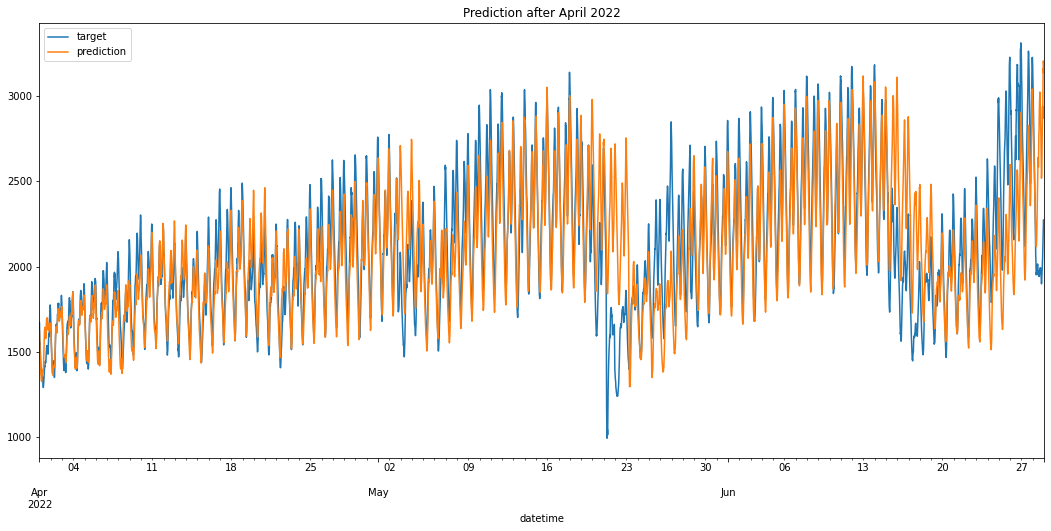

In [ ]:
# Plot after april 2022

plt.figure(figsize=(16,8))
result.set_index('datetime').plot()
plt.title("Prediction after April 2022")

Text(0.5, 1.0, 'Prediction after April 2022')

<Figure size 1152x576 with 0 Axes>

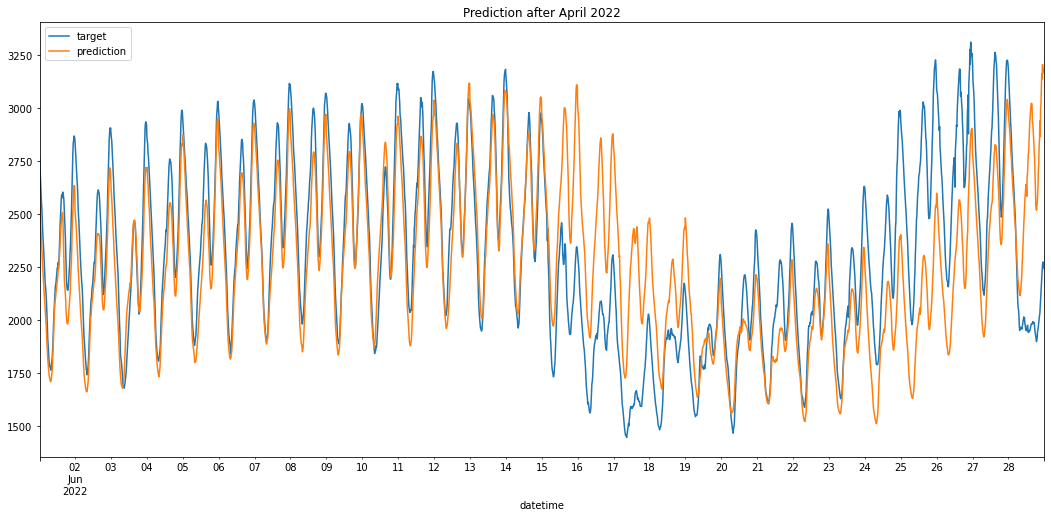

In [ ]:
# Plotting for April2022 

plt.figure(figsize=(16,8))
mask = (result.datetime > '2022-06-01 00:00:00')
result.loc[mask, :].set_index('datetime').plot()
plt.title("Prediction after April 2022")

In [ ]:
"""
One go code for prediction
"""


import os
import pandas as pd
import numpy as np
import pickle
import math
import datetime
from datetime import date

# Reading all the given files
df = pd.read_parquet('/content/drive/MyDrive/w5-6/data/historical_load_data.parquet')
holidays = pd.read_csv('/content/drive/MyDrive/w5-6/data/holidays.csv')
weather = pd.read_parquet('/content/drive/MyDrive/w5-6/data/weather_data.parquet')

# Converting datetime columns to relevant dtypes
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['datetime']).dt.date

df = df.sort_values('datetime')
df = df[['datetime', 'date', 'load', 'tb']].copy()

# Working with holidays file and marking HOLIDAY FLAG on df dataframe
holiday_df = pd.melt(holidays, var_name='holiday_name', value_name='holiday_date')
holiday_df['date'] = pd.to_datetime(holiday_df['holiday_date']).dt.date
df['HOLIDAY FLAG'] = df['date'].isin(holiday_df['date']).map({
    False: 0,
    True: 1
})
df = df[df['HOLIDAY FLAG'] == 0].copy()


# Making a new dataframe of all date_range and merging it to df
start_date = '2011-04-01'
end_date = '2022-06-30'

df2 = pd.DataFrame({
    'datetime': pd.date_range(start_date, periods=96*((date(2022, 6, 30) - date(2011, 4, 1)).days+1), freq='15T')
})
df2['date'] = df2.datetime.dt.date
df2['tb'] = (df2.datetime.dt.hour*60 + df2.datetime.dt.minute)//15 + 1

df2 = pd.merge(df2, df[['datetime', 'load']], how='left', on='datetime')

# Adding more relevant features

best_features = ['tb', 'load', 'dow', 'isNight', 'is_summer', 'cos_tb', 'sin_tb', 'cos_dow', 'sin_dow', 'load_lag_1',
                 'load_lag_2', 'load_lag_96', 'load_lag_192', 'load_rolling_min_96', 'load_wm_1_h', 'hour_mean',
                 'temp_mean_6h', 'temp_mean_9h', 'aptemp_mean_6h', 'aptemp_mean_12h', 'cos_hour', 'sin_hour', 'cos_doy', 'sin_doy']
df2['year'] = df2.datetime.dt.year
df2['month'] = df2.datetime.dt.month
df2['hour'] = df2.datetime.dt.hour
df2['dow'] = df2.datetime.dt.day_of_week
df2['doy'] = df2.datetime.dt.day_of_year
df2['week'] = df2.datetime.dt.week

# Creating only those features that are in best features
df2['isNight'] = ((df2.datetime.dt.hour > 19) | (df2.datetime.dt.hour <= 6)).astype(int)
df2['is_summer'] = ((df2.month > 3) & (df2.month <= 6)).astype(int)  # April, may, june


# sine and cosine features that deals with seasonality
df2['norm'] = 2 * np.pi * df2['tb'] / df2['tb'].max()
df2['cos_tb'] = np.cos(df2['norm'])
df2['sin_tb'] = np.sin(df2['norm'])

df2['norm'] = 2 * np.pi * df2['hour'] / df2['hour'].max()
df2['cos_hour'] = np.cos(df2['norm'])
df2['sin_hour'] = np.sin(df2['norm'])

df2['norm'] = 2 * np.pi * df2['dow'] / df2['dow'].max()
df2['cos_dow'] = np.cos(df2['dow'])
df2['sin_dow'] = np.sin(df2['dow'])

df2['norm'] = 2 * np.pi * df2['doy'] / df2['doy'].max()
df2['cos_doy'] = np.cos(df2['doy'])
df2['sin_doy'] = np.sin(df2['doy'])

df2 = df2.drop(columns=['norm'])

# load lag features
for i in [1, 2, 96, 192]:
    df2[f'load_lag_{i}'] = df2['load'].shift(i).bfill()

# load rolling mean features
df2[f'load_rolling_min_96'] = df2['load'].rolling(96, 1).min().shift().bfill()

# load moving weights features
df2[f'load_wm_1_h'] = df2['load'].ewm(span=4).mean()


# Adding a hour_mean feature and merging it with df2
hour_mean = df2.groupby(['date', 'hour']).load.mean().reset_index()
hour_mean = hour_mean.rename(columns={'load': 'hour_mean'})

df2 = pd.merge(df2, hour_mean, on=['date', 'hour'], how='left')

# Working with weather dataframe
weather.drop_duplicates(inplace=True)

# Removing and replacing outliers in weather dataframe
for i in ['dew_point', 'wind_speed']:
    Q1 = weather[i].quantile(0.25)
    Q3 = weather[i].quantile(0.75)
    IQR = Q3 - Q1

    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR

    if i == 'dew_point':
        weather.loc[weather['dew_point'] < low, 'dew_point'] = low
    elif i == 'wind_speed':
        weather.loc[weather.wind_speed > high, 'wind_speed'] = high

# Adding more relevant features to weather dataframe

weather['temp_mean_6h'] = weather['temperature'].ewm(span=24).mean()
weather['temp_mean_9h'] = weather['temperature'].ewm(span=36).mean()

weather['aptemp_mean_6h'] = weather['apparent_temperature'].ewm(span=36).mean()
weather['aptemp_mean_12h'] = weather['apparent_temperature'].ewm(span=48).mean()

# Merging df2 and weather dataframes as left join
df = pd.merge(df2, weather, how='left', on='datetime')
df = df.drop(columns=['date'])

target = 192
df['ramp'] = df['load'].shift(target)


# PREPARING FINAL DATAFRAME final_df
final_df = df.set_index('datetime')[best_features].copy()
final_df.reset_index(inplace=True)

final_df

,datetime,tb,load,dow,isNight,is_summer,cos_tb,sin_tb,cos_dow,sin_dow,...,load_wm_1_h,hour_mean,temp_mean_6h,temp_mean_9h,aptemp_mean_6h,aptemp_mean_12h,cos_hour,sin_hour,cos_doy,sin_doy
0,2011-04-01 00:00:00,1,NaN,4,1,1,0.997859,6.540313e-02,-0.653644,-0.756802,...,NaN,NaN,26.892207,27.453932,27.457897,27.623132,1.000000,0.000000e+00,-0.994367,0.105988
1,2011-04-01 00:15:00,2,NaN,4,1,1,0.991445,1.305262e-01,-0.653644,-0.756802,...,NaN,NaN,26.710231,27.300612,27.304362,27.500453,1.000000,0.000000e+00,-0.994367,0.105988
2,2011-04-01 00:30:00,3,NaN,4,1,1,0.980785,1.950903e-01,-0.653644,-0.756802,...,NaN,NaN,26.523412,27.142470,27.146018,27.372884,1.000000,0.000000e+00,-0.994367,0.105988
3,2011-04-01 00:45:00,4,NaN,4,1,1,0.965926,2.588190e-01,-0.653644,-0.756802,...,NaN,NaN,26.332139,26.979769,26.983125,27.240623,1.000000,0.000000e+00,-0.994367,0.105988
4,2011-04-01 01:00:00,5,NaN,4,1,1,0.946930,3.214395e-01,-0.653644,-0.756802,...,NaN,NaN,26.136768,26.812755,26.815929,27.103863,0.962917,2.697968e-01,-0.994367,0.105988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394459,2022-06-30 22:45:00,92,2260.0,3,1,1,0.965926,-2.588190e-01,-0.989992,0.141120,...,2211.375028,2210.00,28.331731,28.406918,32.998989,33.296763,0.962917,-2.697968e-01,0.350797,-0.936451
394460,2022-06-30 23:00:00,93,2272.0,3,1,1,0.980785,-1.950903e-01,-0.989992,0.141120,...,2235.625017,2264.75,28.292393,28.376273,32.937963,33.238528,1.000000,-2.449294e-16,0.350797,-0.936451
394461,2022-06-30 23:15:00,94,2274.0,3,1,1,0.991445,-1.305262e-01,-0.989992,0.141120,...,2250.975010,2264.75,28.269001,28.355934,32.954829,33.238996,1.000000,-2.449294e-16,0.350797,-0.936451
394462,2022-06-30 23:30:00,95,2269.0,3,1,1,0.997859,-6.540313e-02,-0.989992,0.141120,...,2258.185006,2264.75,28.247481,28.336695,32.957271,33.229241,1.000000,-2.449294e-16,0.350797,-0.936451


In [ ]:
pickle.dump(reg, open(f'/content/drive/MyDrive/w5-6/reg_model.pkl', 'wb'))

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/w5-6/reg_model.pkl', 'rb'))

### Trying forecasting for 1 day

In [ ]:
test_cutoff = '2022-06-30'
X = final_df.copy()
X_test = X[X['datetime'] >= test_cutoff + ' 00:00:00'].iloc[:, 1:].copy()

pred_test = model.predict(X_test[best_features])

one = pd.read_csv('/content/drive/MyDrive/w5-6/data/2022-07-02.csv')
one.drop_duplicates(inplace=True)
one['datetime'] = pd.to_datetime(one['datetime'])

result = X[X['datetime'] >= test_cutoff + ' 00:00:00'].iloc[:, 0:1].copy()
result['forecast_time'] = result['datetime'] + datetime.timedelta(hours=48)
result['forecast'] = pred_test

In [ ]:
result

,datetime,forecast_time,forecast
394368,2022-06-30 00:00:00,2022-07-02 00:00:00,3010.305019
394369,2022-06-30 00:15:00,2022-07-02 00:15:00,2979.697855
394370,2022-06-30 00:30:00,2022-07-02 00:30:00,2951.741325
394371,2022-06-30 00:45:00,2022-07-02 00:45:00,2915.279289
394372,2022-06-30 01:00:00,2022-07-02 01:00:00,2869.517506
...,...,...,...
394459,2022-06-30 22:45:00,2022-07-02 22:45:00,2440.401241
394460,2022-06-30 23:00:00,2022-07-02 23:00:00,2457.144911
394461,2022-06-30 23:15:00,2022-07-02 23:15:00,2446.603115
394462,2022-06-30 23:30:00,2022-07-02 23:30:00,2444.996614


Text(0.5, 1.0, 'Prediction for 2022-07-02')

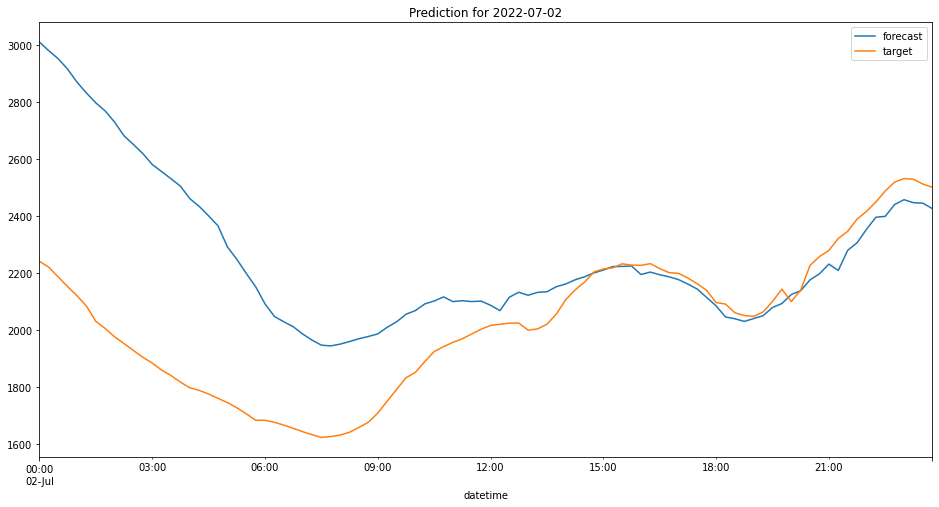

In [ ]:
# Plotting for 2022-07-02, comparing forecasted and given load

fig, ax = plt.subplots(1, figsize=(16,8))
mask = (result.datetime > '2022-06-01 00:00:00')
result.loc[mask, :].set_index('forecast_time')['forecast'].plot(ax=ax)
one.set_index('datetime').load.plot(ax=ax, label='target')
plt.legend()
plt.title("Prediction for 2022-07-02")

In [ ]:
"""
Future Forecasting

This code is the model.py file
"""


import os
import pandas as pd
import numpy as np
import pickle
import math
import datetime
from datetime import date

import warnings
warnings.filterwarnings('ignore')

# Reading all the given files
df = pd.read_parquet('/content/drive/MyDrive/w5-6/data/historical_load_data.parquet')
holidays = pd.read_csv('/content/drive/MyDrive/w5-6/data/holidays.csv')
weather = pd.read_parquet('/content/drive/MyDrive/w5-6/data/weather_data.parquet')
model = pickle.load(open('/content/drive/MyDrive/w5-6/reg_model.pkl', 'rb'))
forecasts = pd.DataFrame()

# Working with weather dataframe
weather.drop_duplicates(inplace=True)

# Removing and replacing outliers in weather dataframe
for i in ['dew_point', 'wind_speed']:
    Q1 = weather[i].quantile(0.25)
    Q3 = weather[i].quantile(0.75)
    IQR = Q3 - Q1

    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR

    if i == 'dew_point':
        weather.loc[weather['dew_point'] < low, 'dew_point'] = low
    elif i == 'wind_speed':
        weather.loc[weather.wind_speed > high, 'wind_speed'] = high


# Adding more relevant features to weather dataframe

weather['temp_mean_6h'] = weather['temperature'].ewm(span=24).mean()
weather['temp_mean_9h'] = weather['temperature'].ewm(span=36).mean()

weather['aptemp_mean_6h'] = weather['apparent_temperature'].ewm(span=36).mean()
weather['aptemp_mean_12h'] = weather['apparent_temperature'].ewm(span=48).mean()


# Making a new dataframe of all date_range and merging it to df
for i in range(1, 4):
  start_date = f'2022-06-{str(30 - i - 1)}'

  dfx = df[pd.to_datetime(df.datetime) >= start_date]

  df2 = pd.DataFrame({
      'datetime': pd.date_range(f'2022-07-01', periods=96*i, freq='15T')
  })
  df2['date'] = df2.datetime.dt.date
  df2['tb'] = (df2.datetime.dt.hour*60 + df2.datetime.dt.minute)//15 + 1

  nums = []
  for xx in range(0, i):
    nums.append(xx + 1)
    files = [f'/content/drive/MyDrive/w5-6/data/2022-07-0{ff}.csv' for ff in nums]
    dff = pd.DataFrame()
    for filename in files:
      dff2 = pd.read_csv(filename)
      dff2.drop_duplicates(inplace=True)
      dff = pd.concat([dff, dff2], ignore_index = True)
  df2['load'] = dff.load

  df2 = dfx.append(df2, ignore_index=True)

  best_features = ['tb', 'load', 'dow', 'isNight', 'is_summer', 'cos_tb', 'sin_tb', 'cos_dow', 'sin_dow', 'load_lag_1',
                  'load_lag_2', 'load_lag_96', 'load_lag_192', 'load_rolling_min_96', 'load_wm_1_h', 'hour_mean',
                  'temp_mean_6h', 'temp_mean_9h', 'aptemp_mean_6h', 'aptemp_mean_12h', 'cos_hour', 'sin_hour', 'cos_doy', 'sin_doy']
  df2['year'] = df2.datetime.dt.year
  df2['month'] = df2.datetime.dt.month
  df2['hour'] = df2.datetime.dt.hour
  df2['dow'] = df2.datetime.dt.day_of_week
  df2['doy'] = df2.datetime.dt.day_of_year
  df2['week'] = df2.datetime.dt.week

  # Creating only those features that are in best features
  df2['isNight'] = ((df2.datetime.dt.hour > 19) | (df2.datetime.dt.hour <= 6)).astype(int)
  df2['is_summer'] = ((df2.month > 3) & (df2.month <= 6)).astype(int)  # April, may, june


  # sine and cosine features that deals with seasonality
  df2['norm'] = 2 * np.pi * df2['tb'] / df2['tb'].max()
  df2['cos_tb'] = np.cos(df2['norm'])
  df2['sin_tb'] = np.sin(df2['norm'])

  df2['norm'] = 2 * np.pi * df2['hour'] / df2['hour'].max()
  df2['cos_hour'] = np.cos(df2['norm'])
  df2['sin_hour'] = np.sin(df2['norm'])

  df2['norm'] = 2 * np.pi * df2['dow'] / df2['dow'].max()
  df2['cos_dow'] = np.cos(df2['dow'])
  df2['sin_dow'] = np.sin(df2['dow'])

  df2['norm'] = 2 * np.pi * df2['doy'] / df2['doy'].max()
  df2['cos_doy'] = np.cos(df2['doy'])
  df2['sin_doy'] = np.sin(df2['doy'])

  df2 = df2.drop(columns=['norm'])

  # load lag features
  for x in [1, 2, 96, 192]:
      df2[f'load_lag_{x}'] = df2['load'].shift(x).bfill()

  # load rolling mean features
  df2[f'load_rolling_min_96'] = df2['load'].rolling(96, 1).min().shift().bfill()

  # load moving weights features
  df2[f'load_wm_1_h'] = df2['load'].ewm(span=4).mean()


  # Adding a hour_mean feature and merging it with df2
  hour_mean = df2.groupby(['date', 'hour']).load.mean().reset_index()
  hour_mean = hour_mean.rename(columns={'load': 'hour_mean'})

  df2 = pd.merge(df2, hour_mean, on=['date', 'hour'], how='left')

  # Merging df2 and weather dataframes as left join
  dfx = pd.merge(df2, weather, how='left', on='datetime')
  dfx = dfx[['datetime'] + best_features].copy()

  test_cutoff = f'2022-07-0{i}'
  dfx = dfx[dfx.datetime >= test_cutoff]

  X = dfx.copy()
  X_test = X.iloc[:, 1:].copy()

  pred_test = model.predict(X_test)

  result = X.iloc[:, 0:1].copy()
  result = result.reset_index()
  result['forecast_time'] = result['datetime'] + datetime.timedelta(hours=48)
  result['forecast'] = pred_test
  result['target'] = pd.Series(dff.load)
  forecasts[f'Forecast_2022_07_0{i}'] = result['forecast']

forecasts.to_csv(f'/content/drive/MyDrive/w5-6/forecasts.csv',index=True)